# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

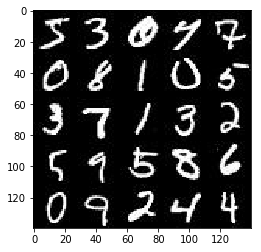

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

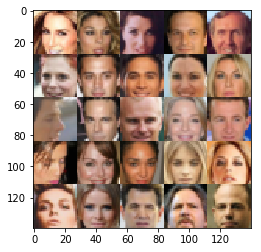

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], 
                                  name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], 
                             name='input_z')
    l_rate = tf.placeholder(tf.float32)

    return (input_images, input_z, l_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\Arist\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\Arist\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\Arist\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\Arist\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\Arist\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def lrelu(layer, alpha):
    return tf.maximum(layer, alpha * layer)

In [8]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """ 
    x_tensor_dim = x_tensor.get_shape().as_list()
    batch_size = tf.shape(x_tensor)[0] # Gives a scalar tensor with the variable batch size. The above list's zero-th element will give a None Type instead.
    flattened_image_size = x_tensor_dim[1] * x_tensor_dim[2] * x_tensor_dim[3]
    
    x_tensor = tf.reshape(x_tensor, [-1, flattened_image_size])
    return x_tensor

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.02
    
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', activation=None)
        conv1 = lrelu(conv1, alpha)
        # Now 14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = lrelu(conv2, alpha)
        # Now 7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, padding='same', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = lrelu(conv3, alpha)
        # Now 4x4x256
        
        conv3 = flatten(conv3)
        
        logits = tf.layers.dense(conv3, 1, activation=None) 
        out = tf.sigmoid(logits)
    
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [59]:
def generator(z, out_channel_dim, is_train=True, keep_prob=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        alpha = 0.02

        layer_1 = tf.layers.dense(z, 7*7*512, activation=None)
        layer_1 = tf.reshape(layer_1, [-1, 7, 7, 512])
        layer_1 = lrelu(layer_1, alpha)
        # Now 7x7x512

        conv1 = tf.layers.conv2d_transpose(layer_1, 256, 5, 2, padding='same', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = lrelu(conv1, alpha)
        conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)
        # Now 14x14x256

        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, 2, padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = lrelu(conv2, alpha)
        conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
        # Now 28x28x128

        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 1, padding='same', activation=None)
        out = tf.tanh(logits)
        # Now 28x28xout_channel_dim

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    g_out = generator(input_z, out_channel_dim, is_train=True)
    
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real) * smooth))
    d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    
    d_loss = d_real + d_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [69]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in train_vars if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [80]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    print_every = 10
    show_every = 100
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                start_time = time.time()
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, lr:learning_rate, inputs_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g),
                      "... Time spent={:.4f}".format(time.time() - start_time))    

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10... Discriminator Loss: 0.7874... Generator Loss: 1.3305 ... Time spent=0.1549
Epoch 1/2 Step 20... Discriminator Loss: 0.6233... Generator Loss: 1.7448 ... Time spent=0.1058
Epoch 1/2 Step 30... Discriminator Loss: 0.5246... Generator Loss: 2.1523 ... Time spent=0.1063
Epoch 1/2 Step 40... Discriminator Loss: 0.6399... Generator Loss: 1.8713 ... Time spent=0.1063
Epoch 1/2 Step 50... Discriminator Loss: 0.6127... Generator Loss: 1.8707 ... Time spent=0.1063
Epoch 1/2 Step 60... Discriminator Loss: 1.0258... Generator Loss: 1.2154 ... Time spent=0.1058
Epoch 1/2 Step 70... Discriminator Loss: 1.3555... Generator Loss: 0.5789 ... Time spent=0.1073
Epoch 1/2 Step 80... Discriminator Loss: 1.0268... Generator Loss: 1.1217 ... Time spent=0.1068
Epoch 1/2 Step 90... Discriminator Loss: 1.1519... Generator Loss: 1.6162 ... Time spent=0.1078
Epoch 1/2 Step 100... Discriminator Loss: 1.0032... Generator Loss: 1.3527 ... Time spent=0.1073


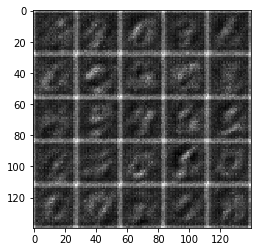

Epoch 1/2 Step 110... Discriminator Loss: 1.1449... Generator Loss: 1.0507 ... Time spent=0.1068
Epoch 1/2 Step 120... Discriminator Loss: 0.9392... Generator Loss: 1.3403 ... Time spent=0.1088
Epoch 1/2 Step 130... Discriminator Loss: 1.0057... Generator Loss: 1.5796 ... Time spent=0.1063
Epoch 1/2 Step 140... Discriminator Loss: 1.0722... Generator Loss: 1.2810 ... Time spent=0.1073
Epoch 1/2 Step 150... Discriminator Loss: 1.2657... Generator Loss: 0.6555 ... Time spent=0.1078
Epoch 1/2 Step 160... Discriminator Loss: 1.0084... Generator Loss: 0.9694 ... Time spent=0.1068
Epoch 1/2 Step 170... Discriminator Loss: 1.3859... Generator Loss: 0.5677 ... Time spent=0.1083
Epoch 1/2 Step 180... Discriminator Loss: 0.9738... Generator Loss: 1.0914 ... Time spent=0.1098
Epoch 1/2 Step 190... Discriminator Loss: 0.8357... Generator Loss: 1.4117 ... Time spent=0.1053
Epoch 1/2 Step 200... Discriminator Loss: 1.0324... Generator Loss: 0.8702 ... Time spent=0.1048


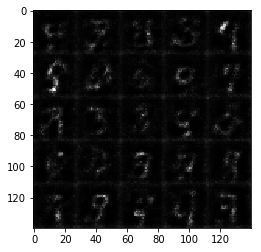

Epoch 1/2 Step 210... Discriminator Loss: 0.9860... Generator Loss: 0.9802 ... Time spent=0.1047
Epoch 1/2 Step 220... Discriminator Loss: 0.7519... Generator Loss: 1.3240 ... Time spent=0.1063
Epoch 1/2 Step 230... Discriminator Loss: 0.7625... Generator Loss: 1.3607 ... Time spent=0.1058
Epoch 1/2 Step 240... Discriminator Loss: 0.8287... Generator Loss: 1.3320 ... Time spent=0.1073
Epoch 1/2 Step 250... Discriminator Loss: 0.7058... Generator Loss: 1.7075 ... Time spent=0.1063
Epoch 1/2 Step 260... Discriminator Loss: 0.6560... Generator Loss: 2.2233 ... Time spent=0.1033
Epoch 1/2 Step 270... Discriminator Loss: 0.7305... Generator Loss: 1.7223 ... Time spent=0.1078
Epoch 1/2 Step 280... Discriminator Loss: 1.1672... Generator Loss: 0.7116 ... Time spent=0.1068
Epoch 1/2 Step 290... Discriminator Loss: 0.9585... Generator Loss: 0.9689 ... Time spent=0.1053
Epoch 1/2 Step 300... Discriminator Loss: 0.9985... Generator Loss: 0.8772 ... Time spent=0.1068


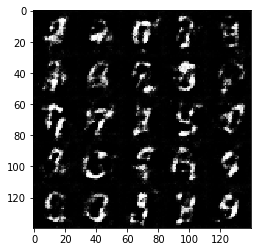

Epoch 1/2 Step 310... Discriminator Loss: 0.6521... Generator Loss: 2.0269 ... Time spent=0.1078
Epoch 1/2 Step 320... Discriminator Loss: 0.7413... Generator Loss: 1.2797 ... Time spent=0.1073
Epoch 1/2 Step 330... Discriminator Loss: 0.9275... Generator Loss: 2.2977 ... Time spent=0.1068
Epoch 1/2 Step 340... Discriminator Loss: 0.6966... Generator Loss: 1.6845 ... Time spent=0.1063
Epoch 1/2 Step 350... Discriminator Loss: 0.5801... Generator Loss: 2.0614 ... Time spent=0.1058
Epoch 1/2 Step 360... Discriminator Loss: 0.7901... Generator Loss: 1.3762 ... Time spent=0.1043
Epoch 1/2 Step 370... Discriminator Loss: 0.8020... Generator Loss: 1.9674 ... Time spent=0.1048
Epoch 1/2 Step 380... Discriminator Loss: 0.7773... Generator Loss: 1.3777 ... Time spent=0.1058
Epoch 1/2 Step 390... Discriminator Loss: 0.6163... Generator Loss: 1.9495 ... Time spent=0.1043
Epoch 1/2 Step 400... Discriminator Loss: 1.1255... Generator Loss: 0.7271 ... Time spent=0.1058


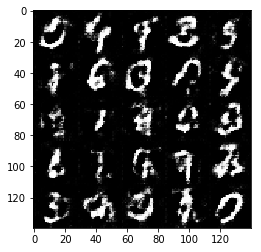

Epoch 1/2 Step 410... Discriminator Loss: 1.1422... Generator Loss: 0.7512 ... Time spent=0.1073
Epoch 1/2 Step 420... Discriminator Loss: 0.6322... Generator Loss: 1.7074 ... Time spent=0.1058
Epoch 1/2 Step 430... Discriminator Loss: 0.7820... Generator Loss: 1.2993 ... Time spent=0.1048
Epoch 1/2 Step 440... Discriminator Loss: 0.8454... Generator Loss: 1.6870 ... Time spent=0.1053
Epoch 1/2 Step 450... Discriminator Loss: 0.7689... Generator Loss: 1.3033 ... Time spent=0.1048
Epoch 1/2 Step 460... Discriminator Loss: 0.8102... Generator Loss: 1.3218 ... Time spent=0.1068
Epoch 1/2 Step 470... Discriminator Loss: 0.6739... Generator Loss: 1.7121 ... Time spent=0.1078
Epoch 1/2 Step 480... Discriminator Loss: 0.8197... Generator Loss: 1.7777 ... Time spent=0.1093
Epoch 1/2 Step 490... Discriminator Loss: 0.8862... Generator Loss: 1.0113 ... Time spent=0.1073
Epoch 1/2 Step 500... Discriminator Loss: 0.8389... Generator Loss: 1.1613 ... Time spent=0.1073


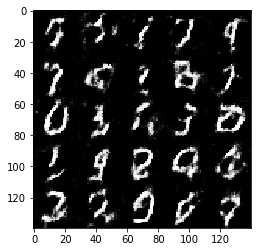

Epoch 1/2 Step 510... Discriminator Loss: 0.9953... Generator Loss: 1.3849 ... Time spent=0.1068
Epoch 1/2 Step 520... Discriminator Loss: 0.8767... Generator Loss: 1.3950 ... Time spent=0.1058
Epoch 1/2 Step 530... Discriminator Loss: 0.7653... Generator Loss: 1.4064 ... Time spent=0.1063
Epoch 1/2 Step 540... Discriminator Loss: 0.7852... Generator Loss: 2.1181 ... Time spent=0.1078
Epoch 1/2 Step 550... Discriminator Loss: 0.9629... Generator Loss: 1.1307 ... Time spent=0.1068
Epoch 1/2 Step 560... Discriminator Loss: 0.9086... Generator Loss: 1.5844 ... Time spent=0.1063
Epoch 1/2 Step 570... Discriminator Loss: 0.9634... Generator Loss: 2.1166 ... Time spent=0.1053
Epoch 1/2 Step 580... Discriminator Loss: 1.1595... Generator Loss: 2.1392 ... Time spent=0.1068
Epoch 1/2 Step 590... Discriminator Loss: 0.8048... Generator Loss: 1.6717 ... Time spent=0.1058
Epoch 1/2 Step 600... Discriminator Loss: 0.9612... Generator Loss: 0.9389 ... Time spent=0.1068


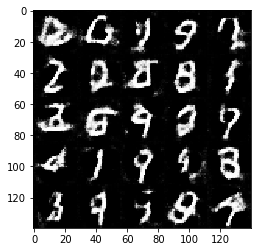

Epoch 1/2 Step 610... Discriminator Loss: 1.0187... Generator Loss: 0.7869 ... Time spent=0.1083
Epoch 1/2 Step 620... Discriminator Loss: 1.0717... Generator Loss: 0.7958 ... Time spent=0.1068
Epoch 1/2 Step 630... Discriminator Loss: 1.0281... Generator Loss: 0.9276 ... Time spent=0.1078
Epoch 1/2 Step 640... Discriminator Loss: 0.8941... Generator Loss: 1.1651 ... Time spent=0.1068
Epoch 1/2 Step 650... Discriminator Loss: 1.0166... Generator Loss: 0.9444 ... Time spent=0.1068
Epoch 1/2 Step 660... Discriminator Loss: 0.9176... Generator Loss: 1.0423 ... Time spent=0.1078
Epoch 1/2 Step 670... Discriminator Loss: 0.7811... Generator Loss: 1.8891 ... Time spent=0.1073
Epoch 1/2 Step 680... Discriminator Loss: 0.8624... Generator Loss: 1.4110 ... Time spent=0.1053
Epoch 1/2 Step 690... Discriminator Loss: 1.0639... Generator Loss: 0.8481 ... Time spent=0.1063
Epoch 1/2 Step 700... Discriminator Loss: 0.9672... Generator Loss: 0.9613 ... Time spent=0.1063


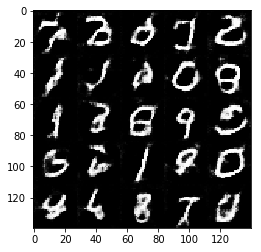

Epoch 1/2 Step 710... Discriminator Loss: 1.0875... Generator Loss: 0.7988 ... Time spent=0.1083
Epoch 1/2 Step 720... Discriminator Loss: 0.8904... Generator Loss: 1.6097 ... Time spent=0.1073
Epoch 1/2 Step 730... Discriminator Loss: 0.8333... Generator Loss: 1.3085 ... Time spent=0.1048
Epoch 1/2 Step 740... Discriminator Loss: 0.8071... Generator Loss: 1.6222 ... Time spent=0.1043
Epoch 1/2 Step 750... Discriminator Loss: 0.7651... Generator Loss: 1.6957 ... Time spent=0.1048
Epoch 1/2 Step 760... Discriminator Loss: 0.6819... Generator Loss: 2.2973 ... Time spent=0.1073
Epoch 1/2 Step 770... Discriminator Loss: 0.9964... Generator Loss: 0.9823 ... Time spent=0.1068
Epoch 1/2 Step 780... Discriminator Loss: 0.7938... Generator Loss: 1.3737 ... Time spent=0.1053
Epoch 1/2 Step 790... Discriminator Loss: 0.9215... Generator Loss: 1.0712 ... Time spent=0.1083
Epoch 1/2 Step 800... Discriminator Loss: 1.5838... Generator Loss: 0.4237 ... Time spent=0.1063


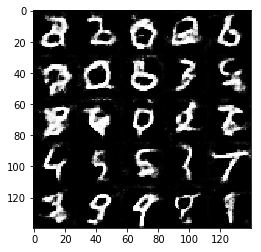

Epoch 1/2 Step 810... Discriminator Loss: 0.6778... Generator Loss: 1.5974 ... Time spent=0.1073
Epoch 1/2 Step 820... Discriminator Loss: 1.0508... Generator Loss: 0.8192 ... Time spent=0.1078
Epoch 1/2 Step 830... Discriminator Loss: 0.8910... Generator Loss: 1.2585 ... Time spent=0.1078
Epoch 1/2 Step 840... Discriminator Loss: 0.7183... Generator Loss: 1.7466 ... Time spent=0.1078
Epoch 1/2 Step 850... Discriminator Loss: 0.8711... Generator Loss: 1.1444 ... Time spent=0.1063
Epoch 1/2 Step 860... Discriminator Loss: 0.8458... Generator Loss: 1.2343 ... Time spent=0.1068
Epoch 1/2 Step 870... Discriminator Loss: 1.0047... Generator Loss: 0.8544 ... Time spent=0.1078
Epoch 1/2 Step 880... Discriminator Loss: 1.3271... Generator Loss: 0.5859 ... Time spent=0.1068
Epoch 1/2 Step 890... Discriminator Loss: 1.0626... Generator Loss: 0.8658 ... Time spent=0.1073
Epoch 1/2 Step 900... Discriminator Loss: 0.7531... Generator Loss: 1.6864 ... Time spent=0.1068


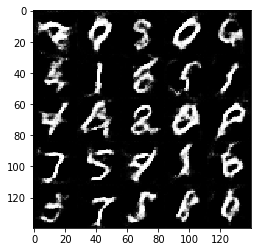

Epoch 1/2 Step 910... Discriminator Loss: 0.8813... Generator Loss: 1.2092 ... Time spent=0.1078
Epoch 1/2 Step 920... Discriminator Loss: 0.8903... Generator Loss: 1.2987 ... Time spent=0.1078
Epoch 1/2 Step 930... Discriminator Loss: 0.9320... Generator Loss: 1.1542 ... Time spent=0.1068
Epoch 1/2 Step 940... Discriminator Loss: 0.9930... Generator Loss: 0.9400 ... Time spent=0.1047
Epoch 1/2 Step 950... Discriminator Loss: 0.8204... Generator Loss: 1.3577 ... Time spent=0.1083
Epoch 1/2 Step 960... Discriminator Loss: 0.9078... Generator Loss: 1.3788 ... Time spent=0.1083
Epoch 1/2 Step 970... Discriminator Loss: 1.0765... Generator Loss: 1.4746 ... Time spent=0.1063
Epoch 1/2 Step 980... Discriminator Loss: 0.8766... Generator Loss: 1.7828 ... Time spent=0.1078
Epoch 1/2 Step 990... Discriminator Loss: 1.0451... Generator Loss: 0.7587 ... Time spent=0.1068
Epoch 1/2 Step 1000... Discriminator Loss: 0.9044... Generator Loss: 1.1884 ... Time spent=0.1073


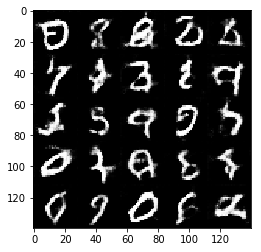

Epoch 1/2 Step 1010... Discriminator Loss: 1.1641... Generator Loss: 0.7377 ... Time spent=0.1048
Epoch 1/2 Step 1020... Discriminator Loss: 0.8843... Generator Loss: 1.2026 ... Time spent=0.1068
Epoch 1/2 Step 1030... Discriminator Loss: 0.9634... Generator Loss: 1.0211 ... Time spent=0.1063
Epoch 1/2 Step 1040... Discriminator Loss: 0.9222... Generator Loss: 1.0064 ... Time spent=0.1067
Epoch 1/2 Step 1050... Discriminator Loss: 0.8994... Generator Loss: 1.0893 ... Time spent=0.1063
Epoch 1/2 Step 1060... Discriminator Loss: 0.8960... Generator Loss: 1.0901 ... Time spent=0.1073
Epoch 1/2 Step 1070... Discriminator Loss: 0.7639... Generator Loss: 1.3508 ... Time spent=0.1053
Epoch 1/2 Step 1080... Discriminator Loss: 0.8868... Generator Loss: 1.2420 ... Time spent=0.1083
Epoch 1/2 Step 1090... Discriminator Loss: 0.9858... Generator Loss: 0.9707 ... Time spent=0.1068
Epoch 1/2 Step 1100... Discriminator Loss: 1.1639... Generator Loss: 0.7196 ... Time spent=0.1073


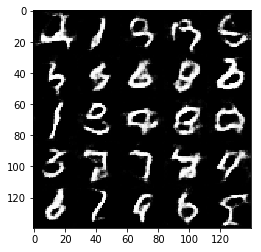

Epoch 1/2 Step 1110... Discriminator Loss: 1.1711... Generator Loss: 0.7823 ... Time spent=0.1063
Epoch 1/2 Step 1120... Discriminator Loss: 0.8817... Generator Loss: 1.5952 ... Time spent=0.1068
Epoch 1/2 Step 1130... Discriminator Loss: 0.9884... Generator Loss: 0.9896 ... Time spent=0.1063
Epoch 1/2 Step 1140... Discriminator Loss: 0.9107... Generator Loss: 1.3489 ... Time spent=0.1083
Epoch 1/2 Step 1150... Discriminator Loss: 0.8825... Generator Loss: 1.4064 ... Time spent=0.1068
Epoch 1/2 Step 1160... Discriminator Loss: 0.8309... Generator Loss: 1.1902 ... Time spent=0.1058
Epoch 1/2 Step 1170... Discriminator Loss: 0.9854... Generator Loss: 0.8908 ... Time spent=0.1053
Epoch 1/2 Step 1180... Discriminator Loss: 0.8443... Generator Loss: 1.2278 ... Time spent=0.1078
Epoch 1/2 Step 1190... Discriminator Loss: 0.9396... Generator Loss: 1.3771 ... Time spent=0.1063
Epoch 1/2 Step 1200... Discriminator Loss: 0.8962... Generator Loss: 1.5347 ... Time spent=0.1063


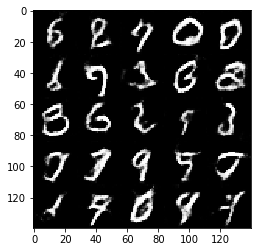

Epoch 1/2 Step 1210... Discriminator Loss: 0.7847... Generator Loss: 1.3415 ... Time spent=0.1058
Epoch 1/2 Step 1220... Discriminator Loss: 0.7994... Generator Loss: 1.5654 ... Time spent=0.1068
Epoch 1/2 Step 1230... Discriminator Loss: 1.1374... Generator Loss: 0.7621 ... Time spent=0.1048
Epoch 1/2 Step 1240... Discriminator Loss: 0.8804... Generator Loss: 1.1284 ... Time spent=0.1053
Epoch 1/2 Step 1250... Discriminator Loss: 0.8002... Generator Loss: 1.5536 ... Time spent=0.1033
Epoch 1/2 Step 1260... Discriminator Loss: 0.9531... Generator Loss: 1.0088 ... Time spent=0.1063
Epoch 1/2 Step 1270... Discriminator Loss: 1.1215... Generator Loss: 0.7421 ... Time spent=0.1063
Epoch 1/2 Step 1280... Discriminator Loss: 0.7839... Generator Loss: 1.9824 ... Time spent=0.1063
Epoch 1/2 Step 1290... Discriminator Loss: 0.9224... Generator Loss: 1.0212 ... Time spent=0.1068
Epoch 1/2 Step 1300... Discriminator Loss: 0.9851... Generator Loss: 0.9495 ... Time spent=0.1078


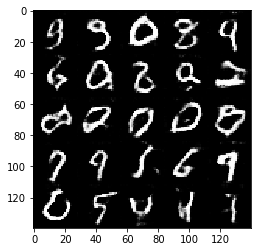

Epoch 1/2 Step 1310... Discriminator Loss: 0.8466... Generator Loss: 1.3269 ... Time spent=0.1063
Epoch 1/2 Step 1320... Discriminator Loss: 0.8992... Generator Loss: 1.0744 ... Time spent=0.1083
Epoch 1/2 Step 1330... Discriminator Loss: 0.9648... Generator Loss: 1.0744 ... Time spent=0.1098
Epoch 1/2 Step 1340... Discriminator Loss: 0.8833... Generator Loss: 1.1073 ... Time spent=0.1068
Epoch 1/2 Step 1350... Discriminator Loss: 1.0295... Generator Loss: 1.4308 ... Time spent=0.1068
Epoch 1/2 Step 1360... Discriminator Loss: 1.0977... Generator Loss: 0.9121 ... Time spent=0.1073
Epoch 1/2 Step 1370... Discriminator Loss: 0.9199... Generator Loss: 1.1482 ... Time spent=0.1063
Epoch 1/2 Step 1380... Discriminator Loss: 0.8615... Generator Loss: 1.1525 ... Time spent=0.1078
Epoch 1/2 Step 1390... Discriminator Loss: 0.7784... Generator Loss: 1.4891 ... Time spent=0.1063
Epoch 1/2 Step 1400... Discriminator Loss: 1.1822... Generator Loss: 0.7126 ... Time spent=0.1047


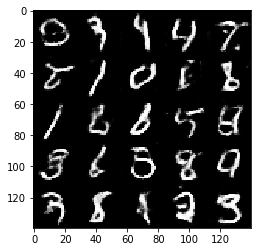

Epoch 1/2 Step 1410... Discriminator Loss: 0.7023... Generator Loss: 1.5170 ... Time spent=0.1068
Epoch 1/2 Step 1420... Discriminator Loss: 0.7799... Generator Loss: 1.3220 ... Time spent=0.1073
Epoch 1/2 Step 1430... Discriminator Loss: 0.9466... Generator Loss: 1.3898 ... Time spent=0.1068
Epoch 1/2 Step 1440... Discriminator Loss: 0.9064... Generator Loss: 1.0978 ... Time spent=0.1078
Epoch 1/2 Step 1450... Discriminator Loss: 0.8290... Generator Loss: 1.2855 ... Time spent=0.1068
Epoch 1/2 Step 1460... Discriminator Loss: 1.0442... Generator Loss: 0.8408 ... Time spent=0.1063
Epoch 1/2 Step 1470... Discriminator Loss: 1.2165... Generator Loss: 0.6542 ... Time spent=0.1093
Epoch 1/2 Step 1480... Discriminator Loss: 0.7233... Generator Loss: 1.4483 ... Time spent=0.1063
Epoch 1/2 Step 1490... Discriminator Loss: 1.1313... Generator Loss: 1.2772 ... Time spent=0.1078
Epoch 1/2 Step 1500... Discriminator Loss: 0.7768... Generator Loss: 1.3059 ... Time spent=0.1073


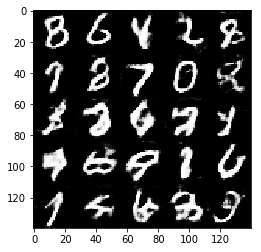

Epoch 1/2 Step 1510... Discriminator Loss: 1.3014... Generator Loss: 0.5843 ... Time spent=0.1073
Epoch 1/2 Step 1520... Discriminator Loss: 0.7028... Generator Loss: 1.6873 ... Time spent=0.1088
Epoch 1/2 Step 1530... Discriminator Loss: 0.9690... Generator Loss: 1.0049 ... Time spent=0.1088
Epoch 1/2 Step 1540... Discriminator Loss: 0.7399... Generator Loss: 1.6867 ... Time spent=0.1068
Epoch 1/2 Step 1550... Discriminator Loss: 0.7459... Generator Loss: 1.8196 ... Time spent=0.1058
Epoch 1/2 Step 1560... Discriminator Loss: 0.9117... Generator Loss: 1.6273 ... Time spent=0.1068
Epoch 1/2 Step 1570... Discriminator Loss: 1.0300... Generator Loss: 1.7078 ... Time spent=0.1058
Epoch 1/2 Step 1580... Discriminator Loss: 0.9315... Generator Loss: 1.2214 ... Time spent=0.1068
Epoch 1/2 Step 1590... Discriminator Loss: 0.7248... Generator Loss: 1.6560 ... Time spent=0.1068
Epoch 1/2 Step 1600... Discriminator Loss: 0.9568... Generator Loss: 0.9606 ... Time spent=0.1078


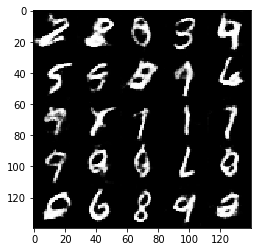

Epoch 1/2 Step 1610... Discriminator Loss: 1.0706... Generator Loss: 1.0336 ... Time spent=0.1078
Epoch 1/2 Step 1620... Discriminator Loss: 0.8254... Generator Loss: 1.0861 ... Time spent=0.1058
Epoch 1/2 Step 1630... Discriminator Loss: 0.7767... Generator Loss: 1.3867 ... Time spent=0.1063
Epoch 1/2 Step 1640... Discriminator Loss: 0.8274... Generator Loss: 1.7301 ... Time spent=0.1063
Epoch 1/2 Step 1650... Discriminator Loss: 0.7332... Generator Loss: 1.5464 ... Time spent=0.1063
Epoch 1/2 Step 1660... Discriminator Loss: 0.8496... Generator Loss: 1.7417 ... Time spent=0.1073
Epoch 1/2 Step 1670... Discriminator Loss: 1.0230... Generator Loss: 0.7752 ... Time spent=0.1058
Epoch 1/2 Step 1680... Discriminator Loss: 0.5861... Generator Loss: 1.9507 ... Time spent=0.1063
Epoch 1/2 Step 1690... Discriminator Loss: 0.7957... Generator Loss: 1.5928 ... Time spent=0.1078
Epoch 1/2 Step 1700... Discriminator Loss: 0.7314... Generator Loss: 1.4364 ... Time spent=0.1063


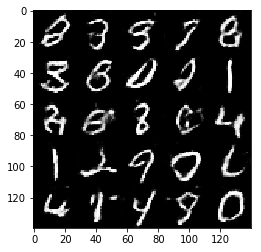

Epoch 1/2 Step 1710... Discriminator Loss: 0.7637... Generator Loss: 1.4836 ... Time spent=0.1068
Epoch 1/2 Step 1720... Discriminator Loss: 0.9251... Generator Loss: 1.4642 ... Time spent=0.1083
Epoch 1/2 Step 1730... Discriminator Loss: 0.9516... Generator Loss: 0.8896 ... Time spent=0.1068
Epoch 1/2 Step 1740... Discriminator Loss: 0.9157... Generator Loss: 1.2586 ... Time spent=0.1053
Epoch 1/2 Step 1750... Discriminator Loss: 0.8939... Generator Loss: 1.5637 ... Time spent=0.1058
Epoch 1/2 Step 1760... Discriminator Loss: 0.9342... Generator Loss: 1.0812 ... Time spent=0.1073
Epoch 1/2 Step 1770... Discriminator Loss: 0.7877... Generator Loss: 1.5072 ... Time spent=0.1053
Epoch 1/2 Step 1780... Discriminator Loss: 0.8269... Generator Loss: 1.3103 ... Time spent=0.1048
Epoch 1/2 Step 1790... Discriminator Loss: 0.6497... Generator Loss: 1.6076 ... Time spent=0.1048
Epoch 1/2 Step 1800... Discriminator Loss: 0.7731... Generator Loss: 1.4017 ... Time spent=0.1063


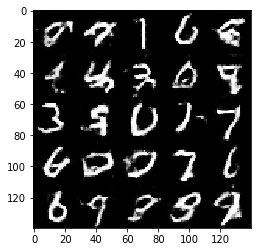

Epoch 1/2 Step 1810... Discriminator Loss: 1.1443... Generator Loss: 0.7514 ... Time spent=0.1073
Epoch 1/2 Step 1820... Discriminator Loss: 0.8092... Generator Loss: 1.5392 ... Time spent=0.1068
Epoch 1/2 Step 1830... Discriminator Loss: 0.9879... Generator Loss: 1.1192 ... Time spent=0.1058
Epoch 1/2 Step 1840... Discriminator Loss: 0.8995... Generator Loss: 0.9840 ... Time spent=0.1053
Epoch 1/2 Step 1850... Discriminator Loss: 0.9766... Generator Loss: 1.5478 ... Time spent=0.1058
Epoch 1/2 Step 1860... Discriminator Loss: 1.3072... Generator Loss: 0.6504 ... Time spent=0.1063
Epoch 1/2 Step 1870... Discriminator Loss: 0.6762... Generator Loss: 1.7356 ... Time spent=0.1073
Epoch 2/2 Step 1880... Discriminator Loss: 0.8554... Generator Loss: 1.1904 ... Time spent=0.1043
Epoch 2/2 Step 1890... Discriminator Loss: 0.7760... Generator Loss: 1.3921 ... Time spent=0.1068
Epoch 2/2 Step 1900... Discriminator Loss: 0.6269... Generator Loss: 1.6100 ... Time spent=0.1073


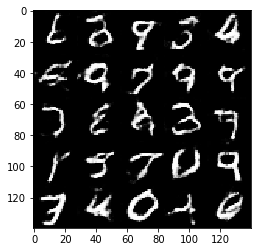

Epoch 2/2 Step 1910... Discriminator Loss: 0.9290... Generator Loss: 1.1502 ... Time spent=0.1063
Epoch 2/2 Step 1920... Discriminator Loss: 0.8372... Generator Loss: 1.1014 ... Time spent=0.1063
Epoch 2/2 Step 1930... Discriminator Loss: 0.8556... Generator Loss: 1.3046 ... Time spent=0.1068
Epoch 2/2 Step 1940... Discriminator Loss: 0.8965... Generator Loss: 1.2191 ... Time spent=0.1063
Epoch 2/2 Step 1950... Discriminator Loss: 0.8167... Generator Loss: 1.2571 ... Time spent=0.1078
Epoch 2/2 Step 1960... Discriminator Loss: 0.9734... Generator Loss: 1.0906 ... Time spent=0.1058
Epoch 2/2 Step 1970... Discriminator Loss: 0.9200... Generator Loss: 1.0796 ... Time spent=0.1048
Epoch 2/2 Step 1980... Discriminator Loss: 0.9617... Generator Loss: 0.9555 ... Time spent=0.1073
Epoch 2/2 Step 1990... Discriminator Loss: 0.6776... Generator Loss: 1.9722 ... Time spent=0.1058
Epoch 2/2 Step 2000... Discriminator Loss: 0.9478... Generator Loss: 0.9682 ... Time spent=0.1073


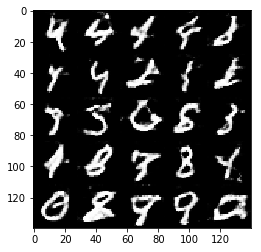

Epoch 2/2 Step 2010... Discriminator Loss: 0.7445... Generator Loss: 1.3534 ... Time spent=0.1073
Epoch 2/2 Step 2020... Discriminator Loss: 0.9295... Generator Loss: 1.2516 ... Time spent=0.1053
Epoch 2/2 Step 2030... Discriminator Loss: 0.9087... Generator Loss: 0.9843 ... Time spent=0.1053
Epoch 2/2 Step 2040... Discriminator Loss: 0.7342... Generator Loss: 1.4162 ... Time spent=0.1073
Epoch 2/2 Step 2050... Discriminator Loss: 0.7942... Generator Loss: 1.2868 ... Time spent=0.1078
Epoch 2/2 Step 2060... Discriminator Loss: 0.7767... Generator Loss: 1.4278 ... Time spent=0.1068
Epoch 2/2 Step 2070... Discriminator Loss: 0.8194... Generator Loss: 1.4902 ... Time spent=0.1068
Epoch 2/2 Step 2080... Discriminator Loss: 0.9152... Generator Loss: 1.0481 ... Time spent=0.1053
Epoch 2/2 Step 2090... Discriminator Loss: 1.0085... Generator Loss: 0.8850 ... Time spent=0.1073
Epoch 2/2 Step 2100... Discriminator Loss: 0.7524... Generator Loss: 1.3562 ... Time spent=0.1083


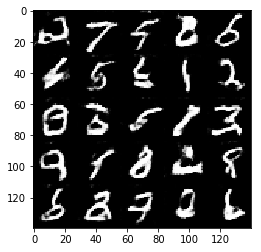

Epoch 2/2 Step 2110... Discriminator Loss: 1.0918... Generator Loss: 0.7870 ... Time spent=0.1068
Epoch 2/2 Step 2120... Discriminator Loss: 0.8785... Generator Loss: 1.2704 ... Time spent=0.1053
Epoch 2/2 Step 2130... Discriminator Loss: 0.8044... Generator Loss: 1.1313 ... Time spent=0.1048
Epoch 2/2 Step 2140... Discriminator Loss: 0.8260... Generator Loss: 1.7703 ... Time spent=0.1058
Epoch 2/2 Step 2150... Discriminator Loss: 0.8886... Generator Loss: 1.0579 ... Time spent=0.1053
Epoch 2/2 Step 2160... Discriminator Loss: 0.9007... Generator Loss: 1.0856 ... Time spent=0.1063
Epoch 2/2 Step 2170... Discriminator Loss: 0.8311... Generator Loss: 1.3356 ... Time spent=0.1058
Epoch 2/2 Step 2180... Discriminator Loss: 0.9484... Generator Loss: 1.0749 ... Time spent=0.1068
Epoch 2/2 Step 2190... Discriminator Loss: 0.7944... Generator Loss: 1.6217 ... Time spent=0.1078
Epoch 2/2 Step 2200... Discriminator Loss: 0.8811... Generator Loss: 1.4956 ... Time spent=0.1063


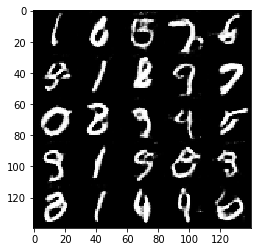

Epoch 2/2 Step 2210... Discriminator Loss: 0.7986... Generator Loss: 2.0011 ... Time spent=0.1058
Epoch 2/2 Step 2220... Discriminator Loss: 0.7505... Generator Loss: 1.5192 ... Time spent=0.1068
Epoch 2/2 Step 2230... Discriminator Loss: 0.7498... Generator Loss: 1.2589 ... Time spent=0.1068
Epoch 2/2 Step 2240... Discriminator Loss: 0.7710... Generator Loss: 1.5613 ... Time spent=0.1073
Epoch 2/2 Step 2250... Discriminator Loss: 0.7253... Generator Loss: 1.9208 ... Time spent=0.1078
Epoch 2/2 Step 2260... Discriminator Loss: 0.6789... Generator Loss: 1.6203 ... Time spent=0.1068
Epoch 2/2 Step 2270... Discriminator Loss: 0.8940... Generator Loss: 1.1957 ... Time spent=0.1053
Epoch 2/2 Step 2280... Discriminator Loss: 0.7767... Generator Loss: 1.8454 ... Time spent=0.1058
Epoch 2/2 Step 2290... Discriminator Loss: 0.9690... Generator Loss: 0.9409 ... Time spent=0.1058
Epoch 2/2 Step 2300... Discriminator Loss: 0.8639... Generator Loss: 1.2097 ... Time spent=0.1058


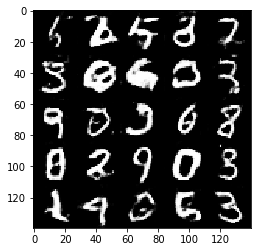

Epoch 2/2 Step 2310... Discriminator Loss: 1.0369... Generator Loss: 1.3687 ... Time spent=0.1063
Epoch 2/2 Step 2320... Discriminator Loss: 0.8810... Generator Loss: 1.1208 ... Time spent=0.1068
Epoch 2/2 Step 2330... Discriminator Loss: 0.9671... Generator Loss: 1.0806 ... Time spent=0.1063
Epoch 2/2 Step 2340... Discriminator Loss: 1.1564... Generator Loss: 0.7734 ... Time spent=0.1048
Epoch 2/2 Step 2350... Discriminator Loss: 0.6415... Generator Loss: 1.8196 ... Time spent=0.1078
Epoch 2/2 Step 2360... Discriminator Loss: 0.7745... Generator Loss: 1.3457 ... Time spent=0.1073
Epoch 2/2 Step 2370... Discriminator Loss: 0.7674... Generator Loss: 1.2466 ... Time spent=0.1053
Epoch 2/2 Step 2380... Discriminator Loss: 1.1799... Generator Loss: 0.8059 ... Time spent=0.1053
Epoch 2/2 Step 2390... Discriminator Loss: 0.7837... Generator Loss: 1.3822 ... Time spent=0.1073
Epoch 2/2 Step 2400... Discriminator Loss: 0.9425... Generator Loss: 0.9267 ... Time spent=0.1058


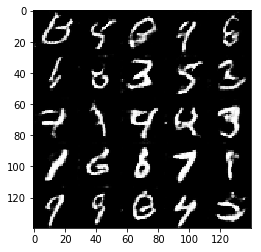

Epoch 2/2 Step 2410... Discriminator Loss: 0.8130... Generator Loss: 1.2316 ... Time spent=0.1062
Epoch 2/2 Step 2420... Discriminator Loss: 0.6737... Generator Loss: 2.1049 ... Time spent=0.1053
Epoch 2/2 Step 2430... Discriminator Loss: 0.7758... Generator Loss: 1.2960 ... Time spent=0.1063
Epoch 2/2 Step 2440... Discriminator Loss: 1.0807... Generator Loss: 0.7915 ... Time spent=0.1053
Epoch 2/2 Step 2450... Discriminator Loss: 0.7980... Generator Loss: 1.5027 ... Time spent=0.1068
Epoch 2/2 Step 2460... Discriminator Loss: 1.1379... Generator Loss: 0.8005 ... Time spent=0.1053
Epoch 2/2 Step 2470... Discriminator Loss: 0.8991... Generator Loss: 1.6081 ... Time spent=0.1073
Epoch 2/2 Step 2480... Discriminator Loss: 0.6720... Generator Loss: 1.6182 ... Time spent=0.1073
Epoch 2/2 Step 2490... Discriminator Loss: 0.9486... Generator Loss: 0.9742 ... Time spent=0.1068
Epoch 2/2 Step 2500... Discriminator Loss: 0.8114... Generator Loss: 1.3493 ... Time spent=0.1073


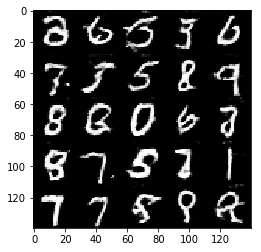

Epoch 2/2 Step 2510... Discriminator Loss: 1.3088... Generator Loss: 1.5283 ... Time spent=0.1063
Epoch 2/2 Step 2520... Discriminator Loss: 0.6676... Generator Loss: 1.5303 ... Time spent=0.1053
Epoch 2/2 Step 2530... Discriminator Loss: 1.2809... Generator Loss: 0.6127 ... Time spent=0.1078
Epoch 2/2 Step 2540... Discriminator Loss: 0.8667... Generator Loss: 1.3028 ... Time spent=0.1053
Epoch 2/2 Step 2550... Discriminator Loss: 0.7468... Generator Loss: 1.3454 ... Time spent=0.1068
Epoch 2/2 Step 2560... Discriminator Loss: 0.9846... Generator Loss: 0.9045 ... Time spent=0.1063
Epoch 2/2 Step 2570... Discriminator Loss: 0.9048... Generator Loss: 0.9374 ... Time spent=0.1058
Epoch 2/2 Step 2580... Discriminator Loss: 0.8581... Generator Loss: 1.2389 ... Time spent=0.1058
Epoch 2/2 Step 2590... Discriminator Loss: 0.9956... Generator Loss: 1.0118 ... Time spent=0.1073
Epoch 2/2 Step 2600... Discriminator Loss: 0.7952... Generator Loss: 1.3451 ... Time spent=0.1083


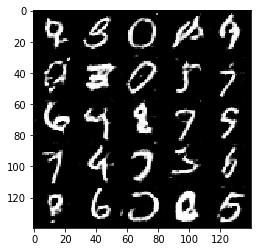

Epoch 2/2 Step 2610... Discriminator Loss: 0.7692... Generator Loss: 1.4287 ... Time spent=0.1058
Epoch 2/2 Step 2620... Discriminator Loss: 0.8876... Generator Loss: 1.0546 ... Time spent=0.1058
Epoch 2/2 Step 2630... Discriminator Loss: 0.8720... Generator Loss: 1.0146 ... Time spent=0.1063
Epoch 2/2 Step 2640... Discriminator Loss: 1.2734... Generator Loss: 0.5569 ... Time spent=0.1068
Epoch 2/2 Step 2650... Discriminator Loss: 1.0335... Generator Loss: 0.9274 ... Time spent=0.1053
Epoch 2/2 Step 2660... Discriminator Loss: 0.8929... Generator Loss: 2.4915 ... Time spent=0.1073
Epoch 2/2 Step 2670... Discriminator Loss: 0.8801... Generator Loss: 1.2609 ... Time spent=0.1063
Epoch 2/2 Step 2680... Discriminator Loss: 0.7845... Generator Loss: 2.4008 ... Time spent=0.1058
Epoch 2/2 Step 2690... Discriminator Loss: 0.7237... Generator Loss: 1.3900 ... Time spent=0.1063
Epoch 2/2 Step 2700... Discriminator Loss: 1.1297... Generator Loss: 0.6697 ... Time spent=0.1078


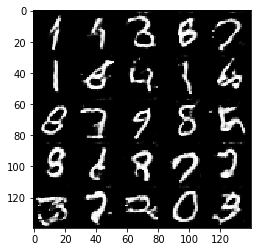

Epoch 2/2 Step 2710... Discriminator Loss: 0.7274... Generator Loss: 1.9598 ... Time spent=0.1048
Epoch 2/2 Step 2720... Discriminator Loss: 1.0100... Generator Loss: 0.9792 ... Time spent=0.1058
Epoch 2/2 Step 2730... Discriminator Loss: 1.2073... Generator Loss: 0.6681 ... Time spent=0.1063
Epoch 2/2 Step 2740... Discriminator Loss: 0.6549... Generator Loss: 1.6682 ... Time spent=0.1068
Epoch 2/2 Step 2750... Discriminator Loss: 0.7382... Generator Loss: 1.2300 ... Time spent=0.1068
Epoch 2/2 Step 2760... Discriminator Loss: 0.8511... Generator Loss: 1.2615 ... Time spent=0.1068
Epoch 2/2 Step 2770... Discriminator Loss: 0.7406... Generator Loss: 1.7616 ... Time spent=0.1053
Epoch 2/2 Step 2780... Discriminator Loss: 0.6131... Generator Loss: 2.0031 ... Time spent=0.1058
Epoch 2/2 Step 2790... Discriminator Loss: 1.1815... Generator Loss: 0.7073 ... Time spent=0.1088
Epoch 2/2 Step 2800... Discriminator Loss: 0.8463... Generator Loss: 1.3016 ... Time spent=0.1078


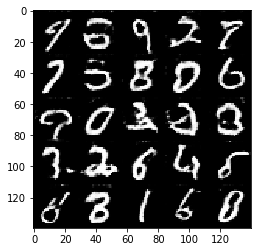

Epoch 2/2 Step 2810... Discriminator Loss: 0.7598... Generator Loss: 1.7144 ... Time spent=0.1073
Epoch 2/2 Step 2820... Discriminator Loss: 0.7651... Generator Loss: 1.3034 ... Time spent=0.1078
Epoch 2/2 Step 2830... Discriminator Loss: 0.5992... Generator Loss: 1.8779 ... Time spent=0.1073
Epoch 2/2 Step 2840... Discriminator Loss: 0.8866... Generator Loss: 2.3593 ... Time spent=0.1098
Epoch 2/2 Step 2850... Discriminator Loss: 1.0587... Generator Loss: 0.8654 ... Time spent=0.1068
Epoch 2/2 Step 2860... Discriminator Loss: 0.9535... Generator Loss: 0.9674 ... Time spent=0.1058
Epoch 2/2 Step 2870... Discriminator Loss: 0.7218... Generator Loss: 1.4847 ... Time spent=0.1058
Epoch 2/2 Step 2880... Discriminator Loss: 0.7527... Generator Loss: 1.4173 ... Time spent=0.1093
Epoch 2/2 Step 2890... Discriminator Loss: 0.7315... Generator Loss: 1.2125 ... Time spent=0.1078
Epoch 2/2 Step 2900... Discriminator Loss: 0.7561... Generator Loss: 2.0729 ... Time spent=0.1093


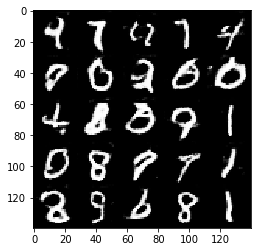

Epoch 2/2 Step 2910... Discriminator Loss: 0.7262... Generator Loss: 1.7524 ... Time spent=0.1063
Epoch 2/2 Step 2920... Discriminator Loss: 0.8290... Generator Loss: 1.3094 ... Time spent=0.1073
Epoch 2/2 Step 2930... Discriminator Loss: 0.7090... Generator Loss: 1.4346 ... Time spent=0.1063
Epoch 2/2 Step 2940... Discriminator Loss: 0.8750... Generator Loss: 1.0654 ... Time spent=0.1098
Epoch 2/2 Step 2950... Discriminator Loss: 0.8026... Generator Loss: 1.3019 ... Time spent=0.1068
Epoch 2/2 Step 2960... Discriminator Loss: 0.8303... Generator Loss: 1.1949 ... Time spent=0.1078
Epoch 2/2 Step 2970... Discriminator Loss: 0.6984... Generator Loss: 2.2323 ... Time spent=0.1068
Epoch 2/2 Step 2980... Discriminator Loss: 0.7613... Generator Loss: 1.3919 ... Time spent=0.1073
Epoch 2/2 Step 2990... Discriminator Loss: 0.9258... Generator Loss: 0.9714 ... Time spent=0.1078
Epoch 2/2 Step 3000... Discriminator Loss: 0.8197... Generator Loss: 2.0958 ... Time spent=0.1073


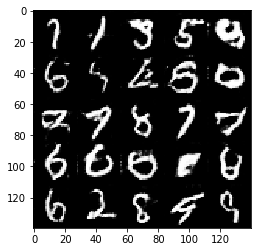

Epoch 2/2 Step 3010... Discriminator Loss: 1.0287... Generator Loss: 0.8898 ... Time spent=0.1098
Epoch 2/2 Step 3020... Discriminator Loss: 0.7146... Generator Loss: 1.3657 ... Time spent=0.1088
Epoch 2/2 Step 3030... Discriminator Loss: 0.7366... Generator Loss: 1.2666 ... Time spent=0.1073
Epoch 2/2 Step 3040... Discriminator Loss: 0.7559... Generator Loss: 1.3224 ... Time spent=0.1088
Epoch 2/2 Step 3050... Discriminator Loss: 0.8051... Generator Loss: 1.1232 ... Time spent=0.1068
Epoch 2/2 Step 3060... Discriminator Loss: 0.5785... Generator Loss: 2.0551 ... Time spent=0.1068
Epoch 2/2 Step 3070... Discriminator Loss: 0.5782... Generator Loss: 2.1632 ... Time spent=0.1073
Epoch 2/2 Step 3080... Discriminator Loss: 0.8349... Generator Loss: 1.1520 ... Time spent=0.1083
Epoch 2/2 Step 3090... Discriminator Loss: 0.9919... Generator Loss: 0.8982 ... Time spent=0.1073
Epoch 2/2 Step 3100... Discriminator Loss: 0.7176... Generator Loss: 1.4526 ... Time spent=0.1068


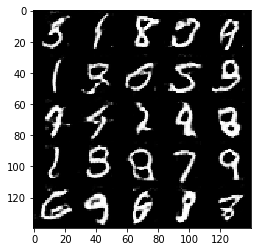

Epoch 2/2 Step 3110... Discriminator Loss: 0.6369... Generator Loss: 1.6097 ... Time spent=0.1073
Epoch 2/2 Step 3120... Discriminator Loss: 0.8742... Generator Loss: 0.9346 ... Time spent=0.1053
Epoch 2/2 Step 3130... Discriminator Loss: 0.9140... Generator Loss: 1.9272 ... Time spent=0.1083
Epoch 2/2 Step 3140... Discriminator Loss: 0.8465... Generator Loss: 1.0985 ... Time spent=0.1068
Epoch 2/2 Step 3150... Discriminator Loss: 0.8854... Generator Loss: 1.0630 ... Time spent=0.1073
Epoch 2/2 Step 3160... Discriminator Loss: 0.8849... Generator Loss: 1.1803 ... Time spent=0.1073
Epoch 2/2 Step 3170... Discriminator Loss: 0.8270... Generator Loss: 1.3054 ... Time spent=0.1078
Epoch 2/2 Step 3180... Discriminator Loss: 0.8619... Generator Loss: 1.0819 ... Time spent=0.1078
Epoch 2/2 Step 3190... Discriminator Loss: 0.6164... Generator Loss: 1.5181 ... Time spent=0.1068
Epoch 2/2 Step 3200... Discriminator Loss: 0.7907... Generator Loss: 1.8597 ... Time spent=0.1083


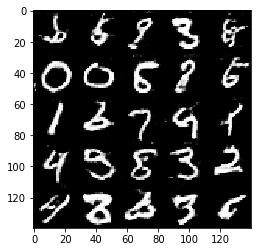

Epoch 2/2 Step 3210... Discriminator Loss: 0.7024... Generator Loss: 1.5242 ... Time spent=0.1053
Epoch 2/2 Step 3220... Discriminator Loss: 0.8522... Generator Loss: 1.6025 ... Time spent=0.1068
Epoch 2/2 Step 3230... Discriminator Loss: 0.7222... Generator Loss: 1.7783 ... Time spent=0.1098
Epoch 2/2 Step 3240... Discriminator Loss: 0.8061... Generator Loss: 1.1830 ... Time spent=0.1073
Epoch 2/2 Step 3250... Discriminator Loss: 0.6282... Generator Loss: 1.9149 ... Time spent=0.1068
Epoch 2/2 Step 3260... Discriminator Loss: 0.6631... Generator Loss: 1.8174 ... Time spent=0.1063
Epoch 2/2 Step 3270... Discriminator Loss: 0.7940... Generator Loss: 1.1947 ... Time spent=0.1078
Epoch 2/2 Step 3280... Discriminator Loss: 0.7908... Generator Loss: 1.9358 ... Time spent=0.1083
Epoch 2/2 Step 3290... Discriminator Loss: 0.8535... Generator Loss: 1.1101 ... Time spent=0.1073
Epoch 2/2 Step 3300... Discriminator Loss: 0.6406... Generator Loss: 1.8534 ... Time spent=0.1068


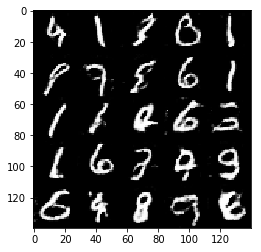

Epoch 2/2 Step 3310... Discriminator Loss: 0.6167... Generator Loss: 1.8743 ... Time spent=0.1073
Epoch 2/2 Step 3320... Discriminator Loss: 0.6525... Generator Loss: 2.2349 ... Time spent=0.1073
Epoch 2/2 Step 3330... Discriminator Loss: 0.8497... Generator Loss: 2.3991 ... Time spent=0.1068
Epoch 2/2 Step 3340... Discriminator Loss: 0.7259... Generator Loss: 2.0548 ... Time spent=0.1078
Epoch 2/2 Step 3350... Discriminator Loss: 0.9420... Generator Loss: 1.0345 ... Time spent=0.1078
Epoch 2/2 Step 3360... Discriminator Loss: 0.5922... Generator Loss: 2.0653 ... Time spent=0.1093
Epoch 2/2 Step 3370... Discriminator Loss: 0.9129... Generator Loss: 1.1784 ... Time spent=0.1058
Epoch 2/2 Step 3380... Discriminator Loss: 0.6928... Generator Loss: 1.5010 ... Time spent=0.1068
Epoch 2/2 Step 3390... Discriminator Loss: 0.6228... Generator Loss: 1.8556 ... Time spent=0.1093
Epoch 2/2 Step 3400... Discriminator Loss: 0.7741... Generator Loss: 1.5832 ... Time spent=0.1073


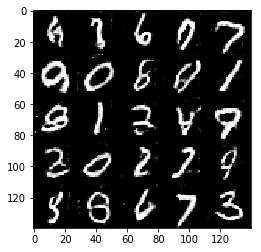

Epoch 2/2 Step 3410... Discriminator Loss: 0.7861... Generator Loss: 1.5739 ... Time spent=0.1078
Epoch 2/2 Step 3420... Discriminator Loss: 0.9111... Generator Loss: 0.9950 ... Time spent=0.1068
Epoch 2/2 Step 3430... Discriminator Loss: 0.8258... Generator Loss: 1.2642 ... Time spent=0.1083
Epoch 2/2 Step 3440... Discriminator Loss: 0.8840... Generator Loss: 1.1191 ... Time spent=0.1083
Epoch 2/2 Step 3450... Discriminator Loss: 0.9088... Generator Loss: 1.0383 ... Time spent=0.1058
Epoch 2/2 Step 3460... Discriminator Loss: 0.7311... Generator Loss: 1.5121 ... Time spent=0.1083
Epoch 2/2 Step 3470... Discriminator Loss: 0.7152... Generator Loss: 2.3827 ... Time spent=0.1103
Epoch 2/2 Step 3480... Discriminator Loss: 0.6515... Generator Loss: 1.5896 ... Time spent=0.1083
Epoch 2/2 Step 3490... Discriminator Loss: 0.9345... Generator Loss: 1.9119 ... Time spent=0.1108
Epoch 2/2 Step 3500... Discriminator Loss: 0.7916... Generator Loss: 1.4113 ... Time spent=0.1073


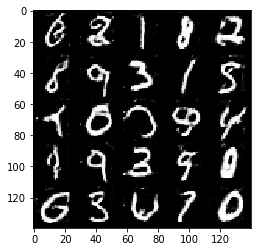

Epoch 2/2 Step 3510... Discriminator Loss: 1.2197... Generator Loss: 0.7077 ... Time spent=0.1083
Epoch 2/2 Step 3520... Discriminator Loss: 0.6470... Generator Loss: 1.4834 ... Time spent=0.1078
Epoch 2/2 Step 3530... Discriminator Loss: 0.8888... Generator Loss: 1.0185 ... Time spent=0.1073
Epoch 2/2 Step 3540... Discriminator Loss: 0.6126... Generator Loss: 2.0501 ... Time spent=0.1068
Epoch 2/2 Step 3550... Discriminator Loss: 0.6773... Generator Loss: 1.5969 ... Time spent=0.1073
Epoch 2/2 Step 3560... Discriminator Loss: 0.8904... Generator Loss: 2.7539 ... Time spent=0.1083
Epoch 2/2 Step 3570... Discriminator Loss: 0.8820... Generator Loss: 1.1718 ... Time spent=0.1088
Epoch 2/2 Step 3580... Discriminator Loss: 0.6915... Generator Loss: 1.4648 ... Time spent=0.1073
Epoch 2/2 Step 3590... Discriminator Loss: 1.9588... Generator Loss: 0.2907 ... Time spent=0.1078
Epoch 2/2 Step 3600... Discriminator Loss: 1.1502... Generator Loss: 0.7090 ... Time spent=0.1073


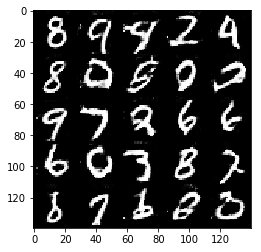

Epoch 2/2 Step 3610... Discriminator Loss: 0.6484... Generator Loss: 1.8082 ... Time spent=0.1078
Epoch 2/2 Step 3620... Discriminator Loss: 0.9874... Generator Loss: 0.9726 ... Time spent=0.1063
Epoch 2/2 Step 3630... Discriminator Loss: 0.6576... Generator Loss: 1.5903 ... Time spent=0.1063
Epoch 2/2 Step 3640... Discriminator Loss: 1.3483... Generator Loss: 0.5419 ... Time spent=0.1078
Epoch 2/2 Step 3650... Discriminator Loss: 0.6100... Generator Loss: 1.9274 ... Time spent=0.1068
Epoch 2/2 Step 3660... Discriminator Loss: 0.7235... Generator Loss: 1.3137 ... Time spent=0.1068
Epoch 2/2 Step 3670... Discriminator Loss: 0.9731... Generator Loss: 1.0401 ... Time spent=0.1073
Epoch 2/2 Step 3680... Discriminator Loss: 0.9891... Generator Loss: 0.8975 ... Time spent=0.1068
Epoch 2/2 Step 3690... Discriminator Loss: 0.7782... Generator Loss: 1.6465 ... Time spent=0.1073
Epoch 2/2 Step 3700... Discriminator Loss: 0.9787... Generator Loss: 0.8985 ... Time spent=0.1068


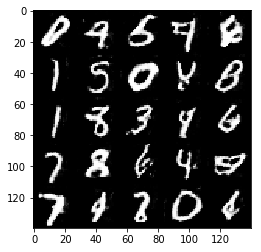

Epoch 2/2 Step 3710... Discriminator Loss: 0.6725... Generator Loss: 1.5999 ... Time spent=0.1088
Epoch 2/2 Step 3720... Discriminator Loss: 0.8016... Generator Loss: 1.3232 ... Time spent=0.1068
Epoch 2/2 Step 3730... Discriminator Loss: 0.6346... Generator Loss: 1.9006 ... Time spent=0.1078
Epoch 2/2 Step 3740... Discriminator Loss: 0.7010... Generator Loss: 1.4513 ... Time spent=0.1063
Epoch 2/2 Step 3750... Discriminator Loss: 0.9127... Generator Loss: 1.2931 ... Time spent=0.1073


In [81]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 10... Discriminator Loss: 0.4359... Generator Loss: 4.2243 ... Time spent=0.2356
Epoch 1/1 Step 20... Discriminator Loss: 0.8738... Generator Loss: 1.4377 ... Time spent=0.1890
Epoch 1/1 Step 30... Discriminator Loss: 0.3863... Generator Loss: 5.3742 ... Time spent=0.1875
Epoch 1/1 Step 40... Discriminator Loss: 0.3586... Generator Loss: 6.9915 ... Time spent=0.1838
Epoch 1/1 Step 50... Discriminator Loss: 0.3410... Generator Loss: 7.2676 ... Time spent=0.1800
Epoch 1/1 Step 60... Discriminator Loss: 0.3582... Generator Loss: 3.7094 ... Time spent=0.1821
Epoch 1/1 Step 70... Discriminator Loss: 0.5536... Generator Loss: 2.6613 ... Time spent=0.1855
Epoch 1/1 Step 80... Discriminator Loss: 0.7848... Generator Loss: 2.5619 ... Time spent=0.1806
Epoch 1/1 Step 90... Discriminator Loss: 0.6401... Generator Loss: 2.3460 ... Time spent=0.1852
Epoch 1/1 Step 100... Discriminator Loss: 0.5149... Generator Loss: 2.5335 ... Time spent=0.1806


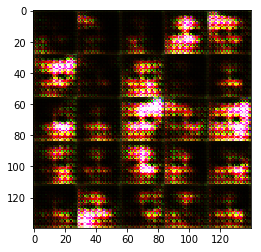

Epoch 1/1 Step 110... Discriminator Loss: 0.6264... Generator Loss: 1.9500 ... Time spent=0.1825
Epoch 1/1 Step 120... Discriminator Loss: 1.5937... Generator Loss: 0.6644 ... Time spent=0.1818
Epoch 1/1 Step 130... Discriminator Loss: 2.3714... Generator Loss: 0.3491 ... Time spent=0.1795
Epoch 1/1 Step 140... Discriminator Loss: 0.9357... Generator Loss: 1.1376 ... Time spent=0.1852
Epoch 1/1 Step 150... Discriminator Loss: 0.4054... Generator Loss: 3.4383 ... Time spent=0.1862
Epoch 1/1 Step 160... Discriminator Loss: 0.4244... Generator Loss: 2.7333 ... Time spent=0.1835
Epoch 1/1 Step 170... Discriminator Loss: 1.3980... Generator Loss: 0.7515 ... Time spent=0.1796
Epoch 1/1 Step 180... Discriminator Loss: 1.2480... Generator Loss: 1.5904 ... Time spent=0.1812
Epoch 1/1 Step 190... Discriminator Loss: 1.4117... Generator Loss: 0.6877 ... Time spent=0.1795
Epoch 1/1 Step 200... Discriminator Loss: 0.7191... Generator Loss: 1.8924 ... Time spent=0.1913


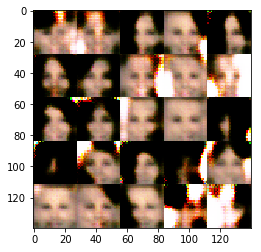

Epoch 1/1 Step 210... Discriminator Loss: 0.8821... Generator Loss: 2.0242 ... Time spent=0.1786
Epoch 1/1 Step 220... Discriminator Loss: 0.9725... Generator Loss: 1.0562 ... Time spent=0.1825
Epoch 1/1 Step 230... Discriminator Loss: 1.1730... Generator Loss: 2.0264 ... Time spent=0.1790
Epoch 1/1 Step 240... Discriminator Loss: 0.6531... Generator Loss: 1.5375 ... Time spent=0.1815
Epoch 1/1 Step 250... Discriminator Loss: 1.1289... Generator Loss: 1.7158 ... Time spent=0.1805
Epoch 1/1 Step 260... Discriminator Loss: 0.5940... Generator Loss: 1.9959 ... Time spent=0.1825
Epoch 1/1 Step 270... Discriminator Loss: 1.2183... Generator Loss: 2.2075 ... Time spent=0.1810
Epoch 1/1 Step 280... Discriminator Loss: 0.6841... Generator Loss: 2.0267 ... Time spent=0.1835
Epoch 1/1 Step 290... Discriminator Loss: 1.4846... Generator Loss: 1.0831 ... Time spent=0.1860
Epoch 1/1 Step 300... Discriminator Loss: 1.0556... Generator Loss: 1.0841 ... Time spent=0.1825


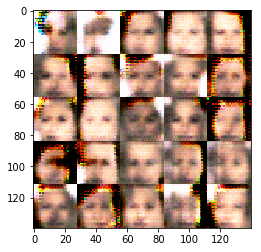

Epoch 1/1 Step 310... Discriminator Loss: 1.9081... Generator Loss: 0.3435 ... Time spent=0.1800
Epoch 1/1 Step 320... Discriminator Loss: 0.8584... Generator Loss: 1.1642 ... Time spent=0.1800
Epoch 1/1 Step 330... Discriminator Loss: 0.9156... Generator Loss: 1.0434 ... Time spent=0.1803
Epoch 1/1 Step 340... Discriminator Loss: 1.0381... Generator Loss: 1.0951 ... Time spent=0.1840
Epoch 1/1 Step 350... Discriminator Loss: 1.0167... Generator Loss: 0.8765 ... Time spent=0.1800
Epoch 1/1 Step 360... Discriminator Loss: 0.9824... Generator Loss: 1.2357 ... Time spent=0.1824
Epoch 1/1 Step 370... Discriminator Loss: 1.0418... Generator Loss: 0.9368 ... Time spent=0.1785
Epoch 1/1 Step 380... Discriminator Loss: 0.6541... Generator Loss: 1.5233 ... Time spent=0.1806
Epoch 1/1 Step 390... Discriminator Loss: 1.4439... Generator Loss: 0.8902 ... Time spent=0.1785
Epoch 1/1 Step 400... Discriminator Loss: 1.1555... Generator Loss: 1.2395 ... Time spent=0.1824


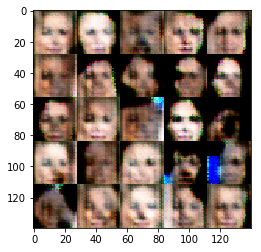

Epoch 1/1 Step 410... Discriminator Loss: 0.7754... Generator Loss: 1.4895 ... Time spent=0.1823
Epoch 1/1 Step 420... Discriminator Loss: 1.7260... Generator Loss: 0.4823 ... Time spent=0.1791
Epoch 1/1 Step 430... Discriminator Loss: 0.9515... Generator Loss: 1.1696 ... Time spent=0.1825
Epoch 1/1 Step 440... Discriminator Loss: 0.7614... Generator Loss: 1.2484 ... Time spent=0.1805
Epoch 1/1 Step 450... Discriminator Loss: 0.9029... Generator Loss: 1.0968 ... Time spent=0.1801
Epoch 1/1 Step 460... Discriminator Loss: 1.0198... Generator Loss: 0.9393 ... Time spent=0.1820
Epoch 1/1 Step 470... Discriminator Loss: 3.0279... Generator Loss: 3.9817 ... Time spent=0.1834
Epoch 1/1 Step 480... Discriminator Loss: 0.7946... Generator Loss: 1.2007 ... Time spent=0.1806
Epoch 1/1 Step 490... Discriminator Loss: 0.9892... Generator Loss: 0.9013 ... Time spent=0.1800
Epoch 1/1 Step 500... Discriminator Loss: 0.9981... Generator Loss: 1.1151 ... Time spent=0.1850


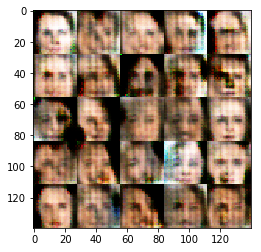

Epoch 1/1 Step 510... Discriminator Loss: 1.4930... Generator Loss: 0.4469 ... Time spent=0.1831
Epoch 1/1 Step 520... Discriminator Loss: 1.1034... Generator Loss: 0.7980 ... Time spent=0.1817
Epoch 1/1 Step 530... Discriminator Loss: 1.4317... Generator Loss: 0.5288 ... Time spent=0.1825
Epoch 1/1 Step 540... Discriminator Loss: 1.0536... Generator Loss: 1.4338 ... Time spent=0.1821
Epoch 1/1 Step 550... Discriminator Loss: 1.2261... Generator Loss: 0.7014 ... Time spent=0.1835
Epoch 1/1 Step 560... Discriminator Loss: 1.4898... Generator Loss: 0.5809 ... Time spent=0.1815
Epoch 1/1 Step 570... Discriminator Loss: 1.0966... Generator Loss: 0.7646 ... Time spent=0.1803
Epoch 1/1 Step 580... Discriminator Loss: 1.0693... Generator Loss: 1.3030 ... Time spent=0.1802
Epoch 1/1 Step 590... Discriminator Loss: 1.1303... Generator Loss: 0.7991 ... Time spent=0.1825
Epoch 1/1 Step 600... Discriminator Loss: 0.9975... Generator Loss: 1.6583 ... Time spent=0.1822


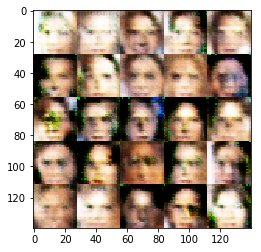

Epoch 1/1 Step 610... Discriminator Loss: 1.0346... Generator Loss: 1.0333 ... Time spent=0.1815
Epoch 1/1 Step 620... Discriminator Loss: 1.4099... Generator Loss: 1.8065 ... Time spent=0.1835
Epoch 1/1 Step 630... Discriminator Loss: 1.2318... Generator Loss: 1.3227 ... Time spent=0.1820
Epoch 1/1 Step 640... Discriminator Loss: 1.2641... Generator Loss: 0.5603 ... Time spent=0.1821
Epoch 1/1 Step 650... Discriminator Loss: 1.0327... Generator Loss: 1.4692 ... Time spent=0.1851
Epoch 1/1 Step 660... Discriminator Loss: 1.0547... Generator Loss: 0.9324 ... Time spent=0.1790
Epoch 1/1 Step 670... Discriminator Loss: 0.8039... Generator Loss: 1.0333 ... Time spent=0.1805
Epoch 1/1 Step 680... Discriminator Loss: 1.2650... Generator Loss: 0.6987 ... Time spent=0.1845
Epoch 1/1 Step 690... Discriminator Loss: 1.2327... Generator Loss: 0.6219 ... Time spent=0.1805
Epoch 1/1 Step 700... Discriminator Loss: 1.0533... Generator Loss: 1.7621 ... Time spent=0.1845


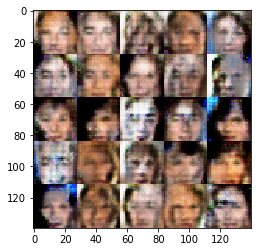

Epoch 1/1 Step 710... Discriminator Loss: 1.3450... Generator Loss: 2.0657 ... Time spent=0.1825
Epoch 1/1 Step 720... Discriminator Loss: 0.9880... Generator Loss: 0.9026 ... Time spent=0.1811
Epoch 1/1 Step 730... Discriminator Loss: 1.0207... Generator Loss: 0.7319 ... Time spent=0.1821
Epoch 1/1 Step 740... Discriminator Loss: 1.5561... Generator Loss: 0.6091 ... Time spent=0.1791
Epoch 1/1 Step 750... Discriminator Loss: 1.3902... Generator Loss: 0.8321 ... Time spent=0.1806
Epoch 1/1 Step 760... Discriminator Loss: 0.9841... Generator Loss: 1.0750 ... Time spent=0.1794
Epoch 1/1 Step 770... Discriminator Loss: 1.3602... Generator Loss: 1.3574 ... Time spent=0.1795
Epoch 1/1 Step 780... Discriminator Loss: 1.2278... Generator Loss: 1.6860 ... Time spent=0.1820
Epoch 1/1 Step 790... Discriminator Loss: 1.2691... Generator Loss: 0.7115 ... Time spent=0.1820
Epoch 1/1 Step 800... Discriminator Loss: 1.3031... Generator Loss: 0.5707 ... Time spent=0.1805


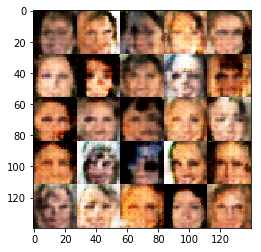

Epoch 1/1 Step 810... Discriminator Loss: 1.1773... Generator Loss: 1.3360 ... Time spent=0.1845
Epoch 1/1 Step 820... Discriminator Loss: 1.2598... Generator Loss: 0.6981 ... Time spent=0.1803
Epoch 1/1 Step 830... Discriminator Loss: 1.3488... Generator Loss: 0.7164 ... Time spent=0.1820
Epoch 1/1 Step 840... Discriminator Loss: 1.6576... Generator Loss: 0.5959 ... Time spent=0.1815
Epoch 1/1 Step 850... Discriminator Loss: 1.0930... Generator Loss: 0.9875 ... Time spent=0.1830
Epoch 1/1 Step 860... Discriminator Loss: 1.0674... Generator Loss: 2.1980 ... Time spent=0.1820
Epoch 1/1 Step 870... Discriminator Loss: 1.2510... Generator Loss: 0.8498 ... Time spent=0.1804
Epoch 1/1 Step 880... Discriminator Loss: 1.0353... Generator Loss: 1.1151 ... Time spent=0.1807
Epoch 1/1 Step 890... Discriminator Loss: 1.1688... Generator Loss: 0.6622 ... Time spent=0.1812
Epoch 1/1 Step 900... Discriminator Loss: 1.1026... Generator Loss: 1.0380 ... Time spent=0.1810


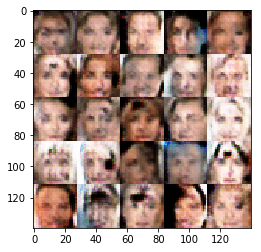

Epoch 1/1 Step 910... Discriminator Loss: 0.9856... Generator Loss: 1.2760 ... Time spent=0.1794
Epoch 1/1 Step 920... Discriminator Loss: 1.1215... Generator Loss: 0.7740 ... Time spent=0.1802
Epoch 1/1 Step 930... Discriminator Loss: 1.0322... Generator Loss: 1.0327 ... Time spent=0.1816
Epoch 1/1 Step 940... Discriminator Loss: 1.2351... Generator Loss: 0.7141 ... Time spent=0.1807
Epoch 1/1 Step 950... Discriminator Loss: 1.1146... Generator Loss: 0.7049 ... Time spent=0.1795
Epoch 1/1 Step 960... Discriminator Loss: 1.2493... Generator Loss: 0.9255 ... Time spent=0.1805
Epoch 1/1 Step 970... Discriminator Loss: 1.3450... Generator Loss: 1.2469 ... Time spent=0.1805
Epoch 1/1 Step 980... Discriminator Loss: 0.9744... Generator Loss: 0.9407 ... Time spent=0.1820
Epoch 1/1 Step 990... Discriminator Loss: 1.2346... Generator Loss: 1.3586 ... Time spent=0.1805
Epoch 1/1 Step 1000... Discriminator Loss: 1.0910... Generator Loss: 1.4362 ... Time spent=0.1804


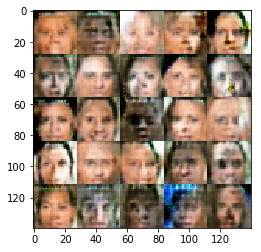

Epoch 1/1 Step 1010... Discriminator Loss: 1.2415... Generator Loss: 1.3192 ... Time spent=0.1805
Epoch 1/1 Step 1020... Discriminator Loss: 1.1361... Generator Loss: 1.0997 ... Time spent=0.1825
Epoch 1/1 Step 1030... Discriminator Loss: 1.9228... Generator Loss: 0.2802 ... Time spent=0.1815
Epoch 1/1 Step 1040... Discriminator Loss: 1.0976... Generator Loss: 1.0986 ... Time spent=0.1785
Epoch 1/1 Step 1050... Discriminator Loss: 1.1478... Generator Loss: 0.9286 ... Time spent=0.1800
Epoch 1/1 Step 1060... Discriminator Loss: 1.0137... Generator Loss: 1.5092 ... Time spent=0.1831
Epoch 1/1 Step 1070... Discriminator Loss: 1.4733... Generator Loss: 0.4568 ... Time spent=0.1825
Epoch 1/1 Step 1080... Discriminator Loss: 1.1335... Generator Loss: 0.9021 ... Time spent=0.1825
Epoch 1/1 Step 1090... Discriminator Loss: 1.3298... Generator Loss: 0.5935 ... Time spent=0.1817
Epoch 1/1 Step 1100... Discriminator Loss: 1.0777... Generator Loss: 1.0466 ... Time spent=0.1800


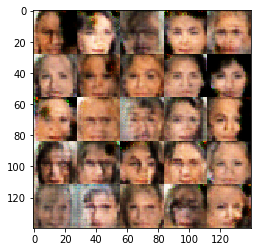

Epoch 1/1 Step 1110... Discriminator Loss: 1.1527... Generator Loss: 0.6874 ... Time spent=0.1810
Epoch 1/1 Step 1120... Discriminator Loss: 1.1514... Generator Loss: 0.9236 ... Time spent=0.1811
Epoch 1/1 Step 1130... Discriminator Loss: 1.1890... Generator Loss: 0.9419 ... Time spent=0.1775
Epoch 1/1 Step 1140... Discriminator Loss: 0.9412... Generator Loss: 0.9389 ... Time spent=0.1809
Epoch 1/1 Step 1150... Discriminator Loss: 1.2160... Generator Loss: 0.5588 ... Time spent=0.1818
Epoch 1/1 Step 1160... Discriminator Loss: 1.4094... Generator Loss: 1.0632 ... Time spent=0.1821
Epoch 1/1 Step 1170... Discriminator Loss: 1.1743... Generator Loss: 0.7493 ... Time spent=0.1830
Epoch 1/1 Step 1180... Discriminator Loss: 1.2628... Generator Loss: 0.9207 ... Time spent=0.1797
Epoch 1/1 Step 1190... Discriminator Loss: 1.1217... Generator Loss: 0.7299 ... Time spent=0.1802
Epoch 1/1 Step 1200... Discriminator Loss: 1.0792... Generator Loss: 0.9018 ... Time spent=0.1810


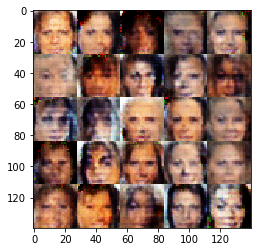

Epoch 1/1 Step 1210... Discriminator Loss: 1.1482... Generator Loss: 1.3412 ... Time spent=0.1793
Epoch 1/1 Step 1220... Discriminator Loss: 1.1754... Generator Loss: 0.9491 ... Time spent=0.1795
Epoch 1/1 Step 1230... Discriminator Loss: 1.1772... Generator Loss: 1.2725 ... Time spent=0.1841
Epoch 1/1 Step 1240... Discriminator Loss: 1.5921... Generator Loss: 1.5483 ... Time spent=0.1815
Epoch 1/1 Step 1250... Discriminator Loss: 1.2847... Generator Loss: 0.5893 ... Time spent=0.1831
Epoch 1/1 Step 1260... Discriminator Loss: 1.0758... Generator Loss: 1.1824 ... Time spent=0.1789
Epoch 1/1 Step 1270... Discriminator Loss: 1.1397... Generator Loss: 0.6735 ... Time spent=0.1815
Epoch 1/1 Step 1280... Discriminator Loss: 1.0778... Generator Loss: 0.7455 ... Time spent=0.1795
Epoch 1/1 Step 1290... Discriminator Loss: 1.2626... Generator Loss: 1.2255 ... Time spent=0.1820
Epoch 1/1 Step 1300... Discriminator Loss: 1.5757... Generator Loss: 0.5901 ... Time spent=0.1800


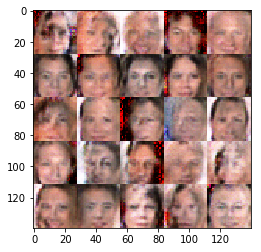

Epoch 1/1 Step 1310... Discriminator Loss: 1.2572... Generator Loss: 1.1070 ... Time spent=0.1817
Epoch 1/1 Step 1320... Discriminator Loss: 1.1160... Generator Loss: 1.5424 ... Time spent=0.1795
Epoch 1/1 Step 1330... Discriminator Loss: 0.9768... Generator Loss: 1.2242 ... Time spent=0.1805
Epoch 1/1 Step 1340... Discriminator Loss: 1.3419... Generator Loss: 3.0399 ... Time spent=0.1811
Epoch 1/1 Step 1350... Discriminator Loss: 1.0811... Generator Loss: 0.9750 ... Time spent=0.1789
Epoch 1/1 Step 1360... Discriminator Loss: 1.0655... Generator Loss: 0.9176 ... Time spent=0.1795
Epoch 1/1 Step 1370... Discriminator Loss: 1.2265... Generator Loss: 1.3011 ... Time spent=0.1795
Epoch 1/1 Step 1380... Discriminator Loss: 1.1036... Generator Loss: 0.7169 ... Time spent=0.1795
Epoch 1/1 Step 1390... Discriminator Loss: 1.2548... Generator Loss: 0.9762 ... Time spent=0.1801
Epoch 1/1 Step 1400... Discriminator Loss: 1.2255... Generator Loss: 1.0942 ... Time spent=0.1811


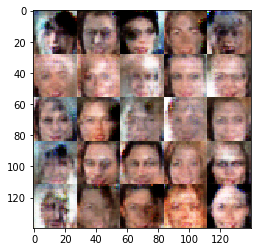

Epoch 1/1 Step 1410... Discriminator Loss: 1.2748... Generator Loss: 0.6903 ... Time spent=0.1818
Epoch 1/1 Step 1420... Discriminator Loss: 1.0617... Generator Loss: 1.0854 ... Time spent=0.1815
Epoch 1/1 Step 1430... Discriminator Loss: 0.9493... Generator Loss: 1.3555 ... Time spent=0.1810
Epoch 1/1 Step 1440... Discriminator Loss: 1.0614... Generator Loss: 0.7811 ... Time spent=0.1801
Epoch 1/1 Step 1450... Discriminator Loss: 1.0761... Generator Loss: 0.9029 ... Time spent=0.1830
Epoch 1/1 Step 1460... Discriminator Loss: 1.1451... Generator Loss: 0.7193 ... Time spent=0.1816
Epoch 1/1 Step 1470... Discriminator Loss: 1.3084... Generator Loss: 1.4023 ... Time spent=0.1810
Epoch 1/1 Step 1480... Discriminator Loss: 1.2666... Generator Loss: 1.0711 ... Time spent=0.1815
Epoch 1/1 Step 1490... Discriminator Loss: 1.3097... Generator Loss: 1.1811 ... Time spent=0.1822
Epoch 1/1 Step 1500... Discriminator Loss: 2.0058... Generator Loss: 0.2528 ... Time spent=0.1815


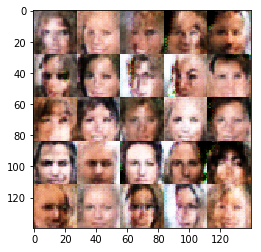

Epoch 1/1 Step 1510... Discriminator Loss: 1.2470... Generator Loss: 1.3091 ... Time spent=0.1814
Epoch 1/1 Step 1520... Discriminator Loss: 1.1857... Generator Loss: 1.1152 ... Time spent=0.1831
Epoch 1/1 Step 1530... Discriminator Loss: 1.1691... Generator Loss: 1.1441 ... Time spent=0.1815
Epoch 1/1 Step 1540... Discriminator Loss: 2.0847... Generator Loss: 0.2496 ... Time spent=0.1815
Epoch 1/1 Step 1550... Discriminator Loss: 1.0633... Generator Loss: 0.9688 ... Time spent=0.1780
Epoch 1/1 Step 1560... Discriminator Loss: 1.0036... Generator Loss: 0.8083 ... Time spent=0.1805
Epoch 1/1 Step 1570... Discriminator Loss: 1.3909... Generator Loss: 0.8830 ... Time spent=0.1795
Epoch 1/1 Step 1580... Discriminator Loss: 1.2240... Generator Loss: 0.8996 ... Time spent=0.1794
Epoch 1/1 Step 1590... Discriminator Loss: 1.2713... Generator Loss: 1.2778 ... Time spent=0.1795
Epoch 1/1 Step 1600... Discriminator Loss: 1.1380... Generator Loss: 0.7654 ... Time spent=0.1811


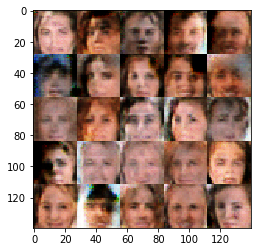

Epoch 1/1 Step 1610... Discriminator Loss: 1.2596... Generator Loss: 1.3818 ... Time spent=0.1795
Epoch 1/1 Step 1620... Discriminator Loss: 1.2578... Generator Loss: 1.2745 ... Time spent=0.1793
Epoch 1/1 Step 1630... Discriminator Loss: 1.0231... Generator Loss: 0.8725 ... Time spent=0.1795
Epoch 1/1 Step 1640... Discriminator Loss: 1.1594... Generator Loss: 0.8526 ... Time spent=0.1811
Epoch 1/1 Step 1650... Discriminator Loss: 0.9510... Generator Loss: 1.3052 ... Time spent=0.1832
Epoch 1/1 Step 1660... Discriminator Loss: 1.2204... Generator Loss: 1.0323 ... Time spent=0.1816
Epoch 1/1 Step 1670... Discriminator Loss: 1.3198... Generator Loss: 0.5846 ... Time spent=0.1820
Epoch 1/1 Step 1680... Discriminator Loss: 1.1847... Generator Loss: 0.7314 ... Time spent=0.1795
Epoch 1/1 Step 1690... Discriminator Loss: 1.3905... Generator Loss: 1.2418 ... Time spent=0.1813
Epoch 1/1 Step 1700... Discriminator Loss: 1.1385... Generator Loss: 1.0841 ... Time spent=0.1797


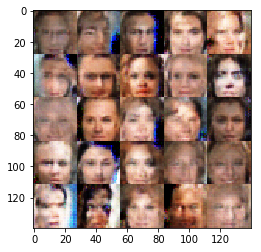

Epoch 1/1 Step 1710... Discriminator Loss: 1.3203... Generator Loss: 0.9189 ... Time spent=0.1810
Epoch 1/1 Step 1720... Discriminator Loss: 1.3211... Generator Loss: 0.6145 ... Time spent=0.1803
Epoch 1/1 Step 1730... Discriminator Loss: 1.3242... Generator Loss: 1.3932 ... Time spent=0.1796
Epoch 1/1 Step 1740... Discriminator Loss: 1.0467... Generator Loss: 0.9042 ... Time spent=0.1835
Epoch 1/1 Step 1750... Discriminator Loss: 1.2093... Generator Loss: 0.6761 ... Time spent=0.1815
Epoch 1/1 Step 1760... Discriminator Loss: 1.0123... Generator Loss: 1.0176 ... Time spent=0.1801
Epoch 1/1 Step 1770... Discriminator Loss: 1.0260... Generator Loss: 0.9317 ... Time spent=0.1790
Epoch 1/1 Step 1780... Discriminator Loss: 1.1015... Generator Loss: 0.6947 ... Time spent=0.1800
Epoch 1/1 Step 1790... Discriminator Loss: 0.9408... Generator Loss: 0.9752 ... Time spent=0.1793
Epoch 1/1 Step 1800... Discriminator Loss: 1.0797... Generator Loss: 0.9448 ... Time spent=0.1805


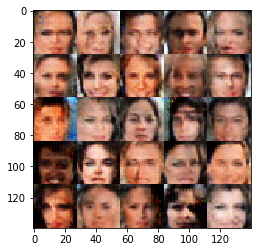

Epoch 1/1 Step 1810... Discriminator Loss: 1.1595... Generator Loss: 1.5747 ... Time spent=0.1815
Epoch 1/1 Step 1820... Discriminator Loss: 1.2845... Generator Loss: 0.7885 ... Time spent=0.1800
Epoch 1/1 Step 1830... Discriminator Loss: 1.1389... Generator Loss: 1.5413 ... Time spent=0.1805
Epoch 1/1 Step 1840... Discriminator Loss: 1.1031... Generator Loss: 0.9152 ... Time spent=0.1831
Epoch 1/1 Step 1850... Discriminator Loss: 1.0614... Generator Loss: 1.0446 ... Time spent=0.1806
Epoch 1/1 Step 1860... Discriminator Loss: 1.1778... Generator Loss: 0.7662 ... Time spent=0.1835
Epoch 1/1 Step 1870... Discriminator Loss: 1.2386... Generator Loss: 0.5596 ... Time spent=0.1813
Epoch 1/1 Step 1880... Discriminator Loss: 1.1691... Generator Loss: 0.6695 ... Time spent=0.1811
Epoch 1/1 Step 1890... Discriminator Loss: 1.2817... Generator Loss: 2.0754 ... Time spent=0.1836
Epoch 1/1 Step 1900... Discriminator Loss: 1.1143... Generator Loss: 0.8208 ... Time spent=0.1817


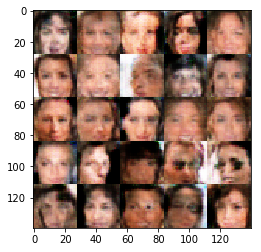

Epoch 1/1 Step 1910... Discriminator Loss: 1.2873... Generator Loss: 1.1959 ... Time spent=0.1793
Epoch 1/1 Step 1920... Discriminator Loss: 1.4777... Generator Loss: 0.7038 ... Time spent=0.1820
Epoch 1/1 Step 1930... Discriminator Loss: 1.4128... Generator Loss: 0.9470 ... Time spent=0.1815
Epoch 1/1 Step 1940... Discriminator Loss: 1.3654... Generator Loss: 0.8153 ... Time spent=0.1815
Epoch 1/1 Step 1950... Discriminator Loss: 1.1086... Generator Loss: 0.8279 ... Time spent=0.1813
Epoch 1/1 Step 1960... Discriminator Loss: 1.0968... Generator Loss: 0.9329 ... Time spent=0.1816
Epoch 1/1 Step 1970... Discriminator Loss: 1.1656... Generator Loss: 0.8160 ... Time spent=0.1814
Epoch 1/1 Step 1980... Discriminator Loss: 1.3378... Generator Loss: 0.9520 ... Time spent=0.1822
Epoch 1/1 Step 1990... Discriminator Loss: 1.1608... Generator Loss: 0.6864 ... Time spent=0.1811
Epoch 1/1 Step 2000... Discriminator Loss: 1.2153... Generator Loss: 0.7478 ... Time spent=0.1815


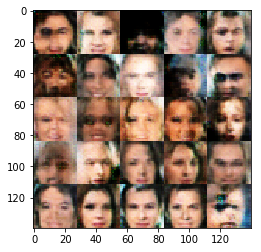

Epoch 1/1 Step 2010... Discriminator Loss: 0.8511... Generator Loss: 1.3141 ... Time spent=0.1805
Epoch 1/1 Step 2020... Discriminator Loss: 1.1747... Generator Loss: 1.1381 ... Time spent=0.1805
Epoch 1/1 Step 2030... Discriminator Loss: 1.2390... Generator Loss: 0.7090 ... Time spent=0.1822
Epoch 1/1 Step 2040... Discriminator Loss: 1.8779... Generator Loss: 0.9486 ... Time spent=0.1815
Epoch 1/1 Step 2050... Discriminator Loss: 1.4263... Generator Loss: 1.6371 ... Time spent=0.1825
Epoch 1/1 Step 2060... Discriminator Loss: 1.0468... Generator Loss: 0.7539 ... Time spent=0.1795
Epoch 1/1 Step 2070... Discriminator Loss: 1.2370... Generator Loss: 0.5903 ... Time spent=0.1792
Epoch 1/1 Step 2080... Discriminator Loss: 1.2985... Generator Loss: 0.9106 ... Time spent=0.1810
Epoch 1/1 Step 2090... Discriminator Loss: 1.2138... Generator Loss: 0.8622 ... Time spent=0.1816
Epoch 1/1 Step 2100... Discriminator Loss: 1.3504... Generator Loss: 1.0471 ... Time spent=0.1814


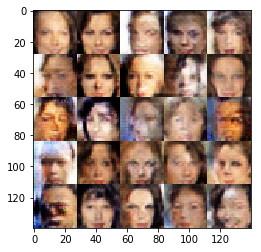

Epoch 1/1 Step 2110... Discriminator Loss: 1.2624... Generator Loss: 0.6012 ... Time spent=0.1830
Epoch 1/1 Step 2120... Discriminator Loss: 1.1376... Generator Loss: 0.8095 ... Time spent=0.1800
Epoch 1/1 Step 2130... Discriminator Loss: 1.0528... Generator Loss: 1.3180 ... Time spent=0.1801
Epoch 1/1 Step 2140... Discriminator Loss: 1.2694... Generator Loss: 0.7893 ... Time spent=0.1785
Epoch 1/1 Step 2150... Discriminator Loss: 1.0401... Generator Loss: 0.8881 ... Time spent=0.1795
Epoch 1/1 Step 2160... Discriminator Loss: 1.2328... Generator Loss: 0.7034 ... Time spent=0.1795
Epoch 1/1 Step 2170... Discriminator Loss: 1.2375... Generator Loss: 0.7886 ... Time spent=0.1795
Epoch 1/1 Step 2180... Discriminator Loss: 1.3300... Generator Loss: 0.7940 ... Time spent=0.1814
Epoch 1/1 Step 2190... Discriminator Loss: 1.2411... Generator Loss: 0.8980 ... Time spent=0.1815
Epoch 1/1 Step 2200... Discriminator Loss: 1.3718... Generator Loss: 0.7351 ... Time spent=0.1820


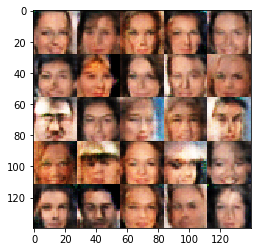

Epoch 1/1 Step 2210... Discriminator Loss: 1.2715... Generator Loss: 0.6842 ... Time spent=0.1815
Epoch 1/1 Step 2220... Discriminator Loss: 1.1248... Generator Loss: 0.9054 ... Time spent=0.1800
Epoch 1/1 Step 2230... Discriminator Loss: 1.1566... Generator Loss: 1.0969 ... Time spent=0.1781
Epoch 1/1 Step 2240... Discriminator Loss: 1.3635... Generator Loss: 0.7520 ... Time spent=0.1790
Epoch 1/1 Step 2250... Discriminator Loss: 0.9059... Generator Loss: 0.9786 ... Time spent=0.1813
Epoch 1/1 Step 2260... Discriminator Loss: 1.2225... Generator Loss: 0.9638 ... Time spent=0.1795
Epoch 1/1 Step 2270... Discriminator Loss: 1.3964... Generator Loss: 1.5332 ... Time spent=0.1794
Epoch 1/1 Step 2280... Discriminator Loss: 1.3527... Generator Loss: 1.1927 ... Time spent=0.1820
Epoch 1/1 Step 2290... Discriminator Loss: 1.0458... Generator Loss: 1.0629 ... Time spent=0.1800
Epoch 1/1 Step 2300... Discriminator Loss: 1.6773... Generator Loss: 0.6082 ... Time spent=0.1830


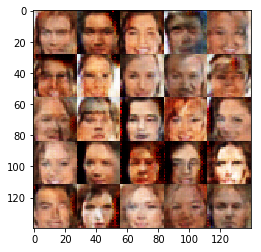

Epoch 1/1 Step 2310... Discriminator Loss: 1.3537... Generator Loss: 0.9026 ... Time spent=0.1806
Epoch 1/1 Step 2320... Discriminator Loss: 1.0728... Generator Loss: 0.9327 ... Time spent=0.1845
Epoch 1/1 Step 2330... Discriminator Loss: 1.2365... Generator Loss: 1.1621 ... Time spent=0.1795
Epoch 1/1 Step 2340... Discriminator Loss: 1.2101... Generator Loss: 0.8613 ... Time spent=0.1805
Epoch 1/1 Step 2350... Discriminator Loss: 1.4521... Generator Loss: 0.7052 ... Time spent=0.1790
Epoch 1/1 Step 2360... Discriminator Loss: 1.5550... Generator Loss: 0.8088 ... Time spent=0.1804
Epoch 1/1 Step 2370... Discriminator Loss: 1.1468... Generator Loss: 0.9010 ... Time spent=0.1791
Epoch 1/1 Step 2380... Discriminator Loss: 1.1652... Generator Loss: 0.8435 ... Time spent=0.1805
Epoch 1/1 Step 2390... Discriminator Loss: 1.3066... Generator Loss: 0.8900 ... Time spent=0.1798
Epoch 1/1 Step 2400... Discriminator Loss: 1.4799... Generator Loss: 0.8598 ... Time spent=0.1805


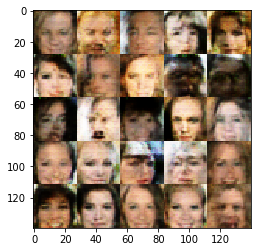

Epoch 1/1 Step 2410... Discriminator Loss: 1.2077... Generator Loss: 0.9911 ... Time spent=0.1815
Epoch 1/1 Step 2420... Discriminator Loss: 1.1928... Generator Loss: 0.8172 ... Time spent=0.1805
Epoch 1/1 Step 2430... Discriminator Loss: 1.3480... Generator Loss: 0.8749 ... Time spent=0.1814
Epoch 1/1 Step 2440... Discriminator Loss: 1.4195... Generator Loss: 0.9781 ... Time spent=0.1814
Epoch 1/1 Step 2450... Discriminator Loss: 1.1710... Generator Loss: 0.9845 ... Time spent=0.1823
Epoch 1/1 Step 2460... Discriminator Loss: 1.3112... Generator Loss: 0.8739 ... Time spent=0.1820
Epoch 1/1 Step 2470... Discriminator Loss: 1.1667... Generator Loss: 1.2681 ... Time spent=0.1822
Epoch 1/1 Step 2480... Discriminator Loss: 1.2218... Generator Loss: 0.8510 ... Time spent=0.1806
Epoch 1/1 Step 2490... Discriminator Loss: 1.1364... Generator Loss: 0.9016 ... Time spent=0.1801
Epoch 1/1 Step 2500... Discriminator Loss: 1.2975... Generator Loss: 0.6397 ... Time spent=0.1791


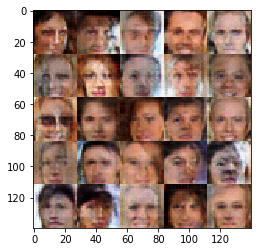

Epoch 1/1 Step 2510... Discriminator Loss: 1.2780... Generator Loss: 1.0349 ... Time spent=0.1825
Epoch 1/1 Step 2520... Discriminator Loss: 1.3008... Generator Loss: 1.1252 ... Time spent=0.1824
Epoch 1/1 Step 2530... Discriminator Loss: 1.3465... Generator Loss: 0.9073 ... Time spent=0.1843
Epoch 1/1 Step 2540... Discriminator Loss: 1.0384... Generator Loss: 0.9031 ... Time spent=0.1822
Epoch 1/1 Step 2550... Discriminator Loss: 1.2562... Generator Loss: 0.7025 ... Time spent=0.1803
Epoch 1/1 Step 2560... Discriminator Loss: 1.2985... Generator Loss: 0.8923 ... Time spent=0.1795
Epoch 1/1 Step 2570... Discriminator Loss: 1.3052... Generator Loss: 0.9163 ... Time spent=0.1815
Epoch 1/1 Step 2580... Discriminator Loss: 1.1310... Generator Loss: 0.9887 ... Time spent=0.1820
Epoch 1/1 Step 2590... Discriminator Loss: 1.1513... Generator Loss: 0.8100 ... Time spent=0.1810
Epoch 1/1 Step 2600... Discriminator Loss: 1.4057... Generator Loss: 0.7717 ... Time spent=0.1825


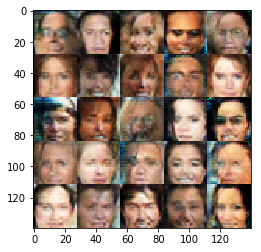

Epoch 1/1 Step 2610... Discriminator Loss: 1.1160... Generator Loss: 0.7984 ... Time spent=0.1790
Epoch 1/1 Step 2620... Discriminator Loss: 1.2839... Generator Loss: 0.6440 ... Time spent=0.1790
Epoch 1/1 Step 2630... Discriminator Loss: 1.2122... Generator Loss: 0.9020 ... Time spent=0.1801
Epoch 1/1 Step 2640... Discriminator Loss: 1.2370... Generator Loss: 0.8571 ... Time spent=0.1795
Epoch 1/1 Step 2650... Discriminator Loss: 1.1626... Generator Loss: 0.7982 ... Time spent=0.1795
Epoch 1/1 Step 2660... Discriminator Loss: 1.2175... Generator Loss: 1.2782 ... Time spent=0.1790
Epoch 1/1 Step 2670... Discriminator Loss: 1.2616... Generator Loss: 0.7984 ... Time spent=0.1805
Epoch 1/1 Step 2680... Discriminator Loss: 1.3247... Generator Loss: 0.7572 ... Time spent=0.1820
Epoch 1/1 Step 2690... Discriminator Loss: 1.2394... Generator Loss: 0.8290 ... Time spent=0.1814
Epoch 1/1 Step 2700... Discriminator Loss: 1.3028... Generator Loss: 0.6387 ... Time spent=0.1810


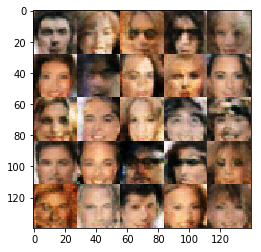

Epoch 1/1 Step 2710... Discriminator Loss: 1.2124... Generator Loss: 0.8386 ... Time spent=0.1800
Epoch 1/1 Step 2720... Discriminator Loss: 1.2974... Generator Loss: 0.8578 ... Time spent=0.1795
Epoch 1/1 Step 2730... Discriminator Loss: 1.4757... Generator Loss: 0.6211 ... Time spent=0.1810
Epoch 1/1 Step 2740... Discriminator Loss: 1.3052... Generator Loss: 1.0103 ... Time spent=0.1813
Epoch 1/1 Step 2750... Discriminator Loss: 1.2982... Generator Loss: 0.6619 ... Time spent=0.1822
Epoch 1/1 Step 2760... Discriminator Loss: 1.6910... Generator Loss: 0.4346 ... Time spent=0.1812
Epoch 1/1 Step 2770... Discriminator Loss: 1.1963... Generator Loss: 0.9095 ... Time spent=0.1820
Epoch 1/1 Step 2780... Discriminator Loss: 1.5074... Generator Loss: 0.7246 ... Time spent=0.1835
Epoch 1/1 Step 2790... Discriminator Loss: 1.1951... Generator Loss: 0.8091 ... Time spent=0.1798
Epoch 1/1 Step 2800... Discriminator Loss: 1.1829... Generator Loss: 0.8465 ... Time spent=0.1810


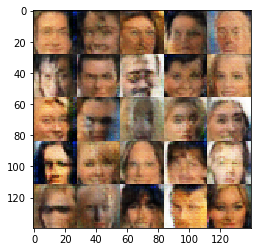

Epoch 1/1 Step 2810... Discriminator Loss: 1.1734... Generator Loss: 0.7738 ... Time spent=0.1814
Epoch 1/1 Step 2820... Discriminator Loss: 1.1101... Generator Loss: 0.8288 ... Time spent=0.1820
Epoch 1/1 Step 2830... Discriminator Loss: 1.2898... Generator Loss: 1.1921 ... Time spent=0.1815
Epoch 1/1 Step 2840... Discriminator Loss: 1.3721... Generator Loss: 0.6935 ... Time spent=0.1825
Epoch 1/1 Step 2850... Discriminator Loss: 1.2386... Generator Loss: 1.2635 ... Time spent=0.1790
Epoch 1/1 Step 2860... Discriminator Loss: 0.7983... Generator Loss: 1.1516 ... Time spent=0.1805
Epoch 1/1 Step 2870... Discriminator Loss: 1.2610... Generator Loss: 0.9363 ... Time spent=0.1815
Epoch 1/1 Step 2880... Discriminator Loss: 1.3625... Generator Loss: 1.0768 ... Time spent=0.1795
Epoch 1/1 Step 2890... Discriminator Loss: 1.3531... Generator Loss: 0.7311 ... Time spent=0.1806
Epoch 1/1 Step 2900... Discriminator Loss: 1.2730... Generator Loss: 0.9684 ... Time spent=0.1803


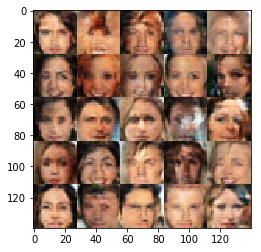

Epoch 1/1 Step 2910... Discriminator Loss: 1.3507... Generator Loss: 0.7688 ... Time spent=0.1827
Epoch 1/1 Step 2920... Discriminator Loss: 1.4792... Generator Loss: 0.7501 ... Time spent=0.1835
Epoch 1/1 Step 2930... Discriminator Loss: 1.1580... Generator Loss: 0.7096 ... Time spent=0.1810
Epoch 1/1 Step 2940... Discriminator Loss: 1.2559... Generator Loss: 1.1063 ... Time spent=0.1825
Epoch 1/1 Step 2950... Discriminator Loss: 1.1752... Generator Loss: 0.8530 ... Time spent=0.1800
Epoch 1/1 Step 2960... Discriminator Loss: 1.2045... Generator Loss: 0.6935 ... Time spent=0.1805
Epoch 1/1 Step 2970... Discriminator Loss: 1.1153... Generator Loss: 0.9022 ... Time spent=0.1795
Epoch 1/1 Step 2980... Discriminator Loss: 1.5186... Generator Loss: 0.6082 ... Time spent=0.1812
Epoch 1/1 Step 2990... Discriminator Loss: 1.0830... Generator Loss: 0.8096 ... Time spent=0.1830
Epoch 1/1 Step 3000... Discriminator Loss: 1.3451... Generator Loss: 0.7296 ... Time spent=0.1821


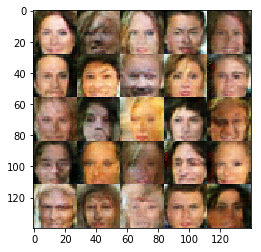

Epoch 1/1 Step 3010... Discriminator Loss: 1.3316... Generator Loss: 0.8825 ... Time spent=0.1803
Epoch 1/1 Step 3020... Discriminator Loss: 1.0875... Generator Loss: 0.8016 ... Time spent=0.1781
Epoch 1/1 Step 3030... Discriminator Loss: 1.3290... Generator Loss: 0.9685 ... Time spent=0.1807
Epoch 1/1 Step 3040... Discriminator Loss: 1.3146... Generator Loss: 0.8020 ... Time spent=0.1810
Epoch 1/1 Step 3050... Discriminator Loss: 1.2253... Generator Loss: 0.8668 ... Time spent=0.1833
Epoch 1/1 Step 3060... Discriminator Loss: 1.3915... Generator Loss: 0.9885 ... Time spent=0.1825
Epoch 1/1 Step 3070... Discriminator Loss: 1.2763... Generator Loss: 0.8520 ... Time spent=0.1810
Epoch 1/1 Step 3080... Discriminator Loss: 1.2827... Generator Loss: 0.9761 ... Time spent=0.1795
Epoch 1/1 Step 3090... Discriminator Loss: 1.3556... Generator Loss: 0.8882 ... Time spent=0.1790
Epoch 1/1 Step 3100... Discriminator Loss: 1.2902... Generator Loss: 0.7413 ... Time spent=0.1815


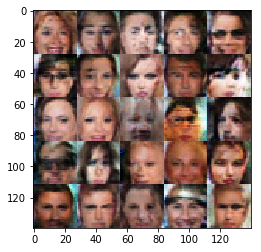

Epoch 1/1 Step 3110... Discriminator Loss: 1.4201... Generator Loss: 0.7453 ... Time spent=0.1832
Epoch 1/1 Step 3120... Discriminator Loss: 1.3063... Generator Loss: 1.0075 ... Time spent=0.1805
Epoch 1/1 Step 3130... Discriminator Loss: 1.1824... Generator Loss: 0.9550 ... Time spent=0.1835
Epoch 1/1 Step 3140... Discriminator Loss: 1.2450... Generator Loss: 0.7980 ... Time spent=0.1775
Epoch 1/1 Step 3150... Discriminator Loss: 1.3931... Generator Loss: 1.2499 ... Time spent=0.1795
Epoch 1/1 Step 3160... Discriminator Loss: 1.2928... Generator Loss: 0.8273 ... Time spent=0.1805


In [82]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.